# Trabajo Final
<br/>

## Curso de Especialización en Inteligencia Artificial
## Inteligencia Artificial Embebida
<br/>

### Autor: Maximiliano Torti
### Fecha: 17/01/21
<br/>

In [92]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
from scipy import fftpack
from scipy.signal import buttord
from scipy.signal import butter
from scipy.signal import lfilter
import wave
import librosa
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree
import itertools

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

## Identificacion de eventos

Primero cargamos los archivos de audio que utilizaremos para identificar eventos

In [2]:
path = './Audios/Detección de eventos masticatorios/'

In [3]:
def load_file(file_path, filename, adq_freq=22050):
    # Read file to get buffer                                                                                               
    ifile = wave.open(file_path+filename+".wav")
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

    # Normalize float32 array so that values are between -1.0 and +1.0                                                      
    max_int16 = 2**15
    audio_normalized = audio_as_np_float32 / max_int16
    timestamp_audio = np.arange(audio_normalized.shape[0])/adq_freq
    df_marks = pd.read_csv(file_path+filename+".txt", sep="\t", header=None, names= ['tstart','tend','class'])
    
    return timestamp_audio,audio_normalized, df_marks

In [4]:
t0, audio0, tmarks0 = load_file(path,"recording_01")
t1, audio1, tmarks1 = load_file(path,"recording_51")
t2, audio2, tmarks2 = load_file(path,"recording_52")

In [5]:
freq_adq = 22050

Graficamos uno de los audios para observar las formas de onda. Superpuesto se grafican con sombreado los eventos, obtenidos de los archivos de marcas temporales

In [6]:
def plot_audio(t, audio, tmarks, tpred=None):
    plt.figure(figsize=(20, 10))
    plt.plot(t,audio,color='blue')
    plt.xlabel("Tiempo[s]")
    for idx in range(len(tmarks)):
        plt.axvspan(tmarks['tstart'].iloc[idx], tmarks['tend'].iloc[idx], color='orange', alpha=0.2, lw=0)
    if tpred is not None:
        for idx in range(len(tpred)):
            plt.axvspan(tpred['tstart'].iloc[idx], tpred['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
    plt.ylabel("Amplitud normalizada")
    plt.title("Forma de onda")
    plt.grid(True)
    plt.show()

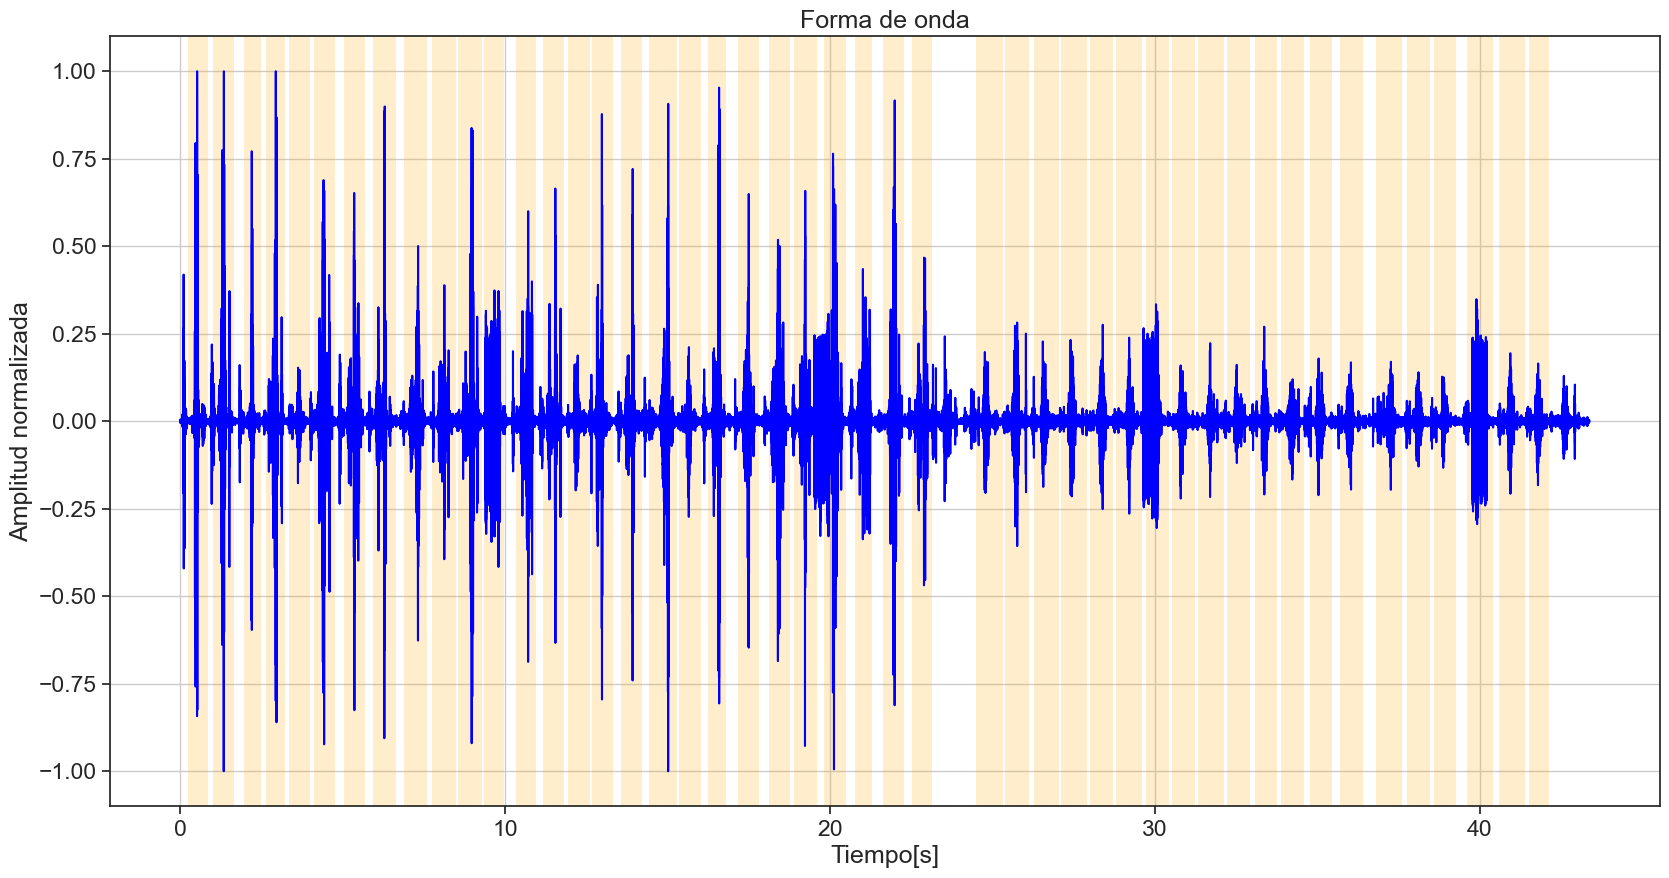

In [7]:
plot_audio(t0,audio0,tmarks0)

Para mayor información, graficamos la transformada de Fourier

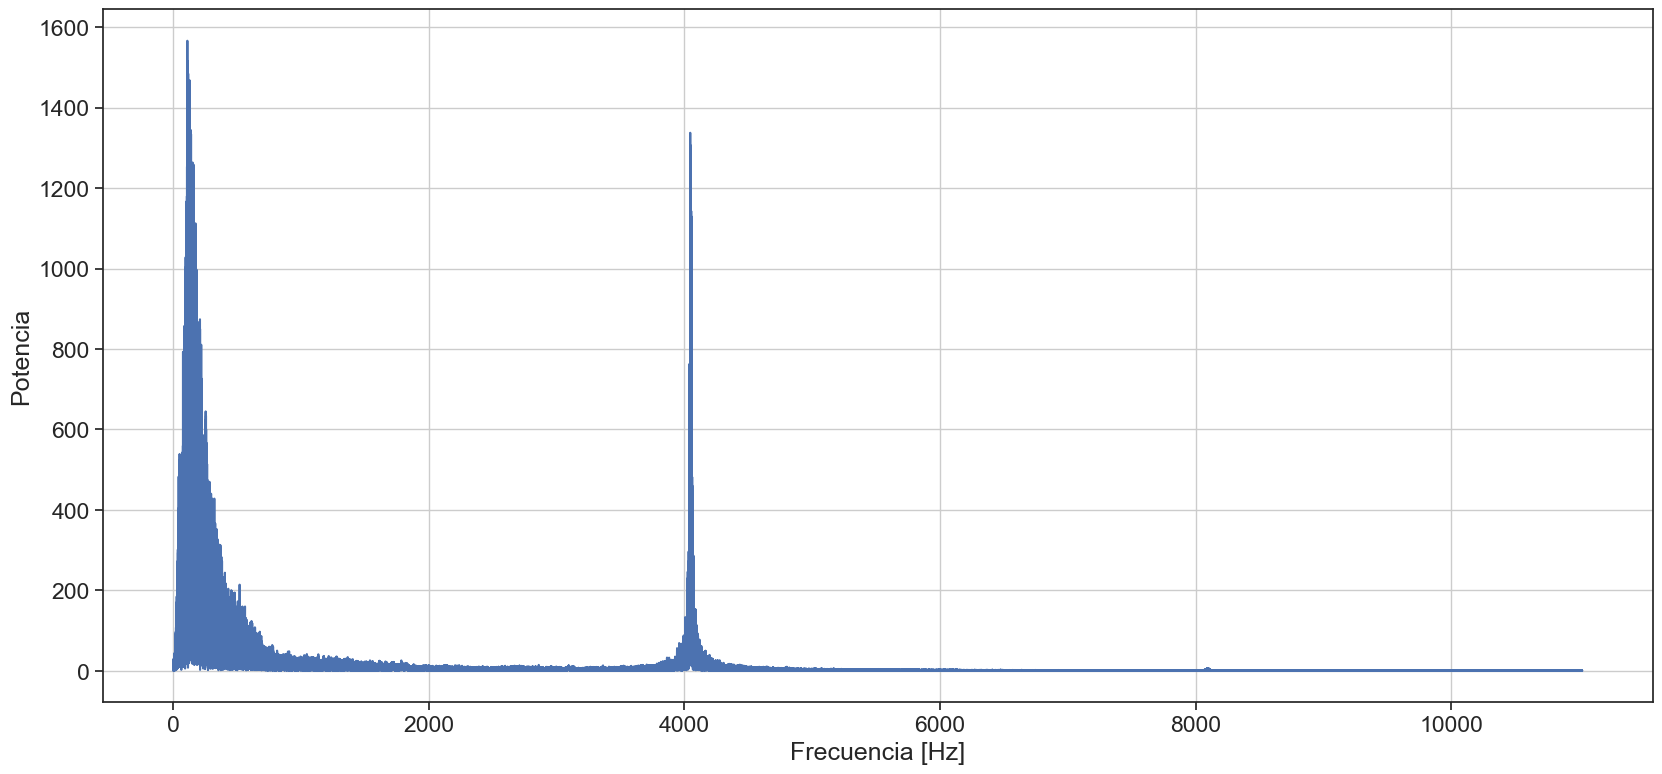

In [8]:
def plot_fft(audio,freq_adq=22050):
    sample_freq = fftpack.fftfreq(len(audio),d=1/freq_adq) 
    sig_fft = fftpack.fft(audio)
    idxs = np.where(sample_freq >= 0)
    freqs = sample_freq[idxs]
    power = np.abs(sig_fft)[idxs]
    plt.plot(freqs, power)
    plt.grid(True)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia')
    plt.show()  

plot_fft(audio0)

Se observa:
- Ruido de 4KHz, este ruido se corresponde con una marca de tiempo utilizada para sincronismo. Es necesario filtrar.
- La mayor parte de la información se encuentra en la banda de 0 a 2KHz.
    
Por estas razones, aplicamos un filtro pasabajo con fc = 2KHz

In [9]:
def noise_filter(audio, wp=2000, ws=2500, gpass=3, gstop=40, freq_adq=22050):
    order, wn = buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=freq_adq)
    b, a = butter(order, wn, btype='lowpass', analog=False, fs=freq_adq)
    return lfilter(b, a, audio)

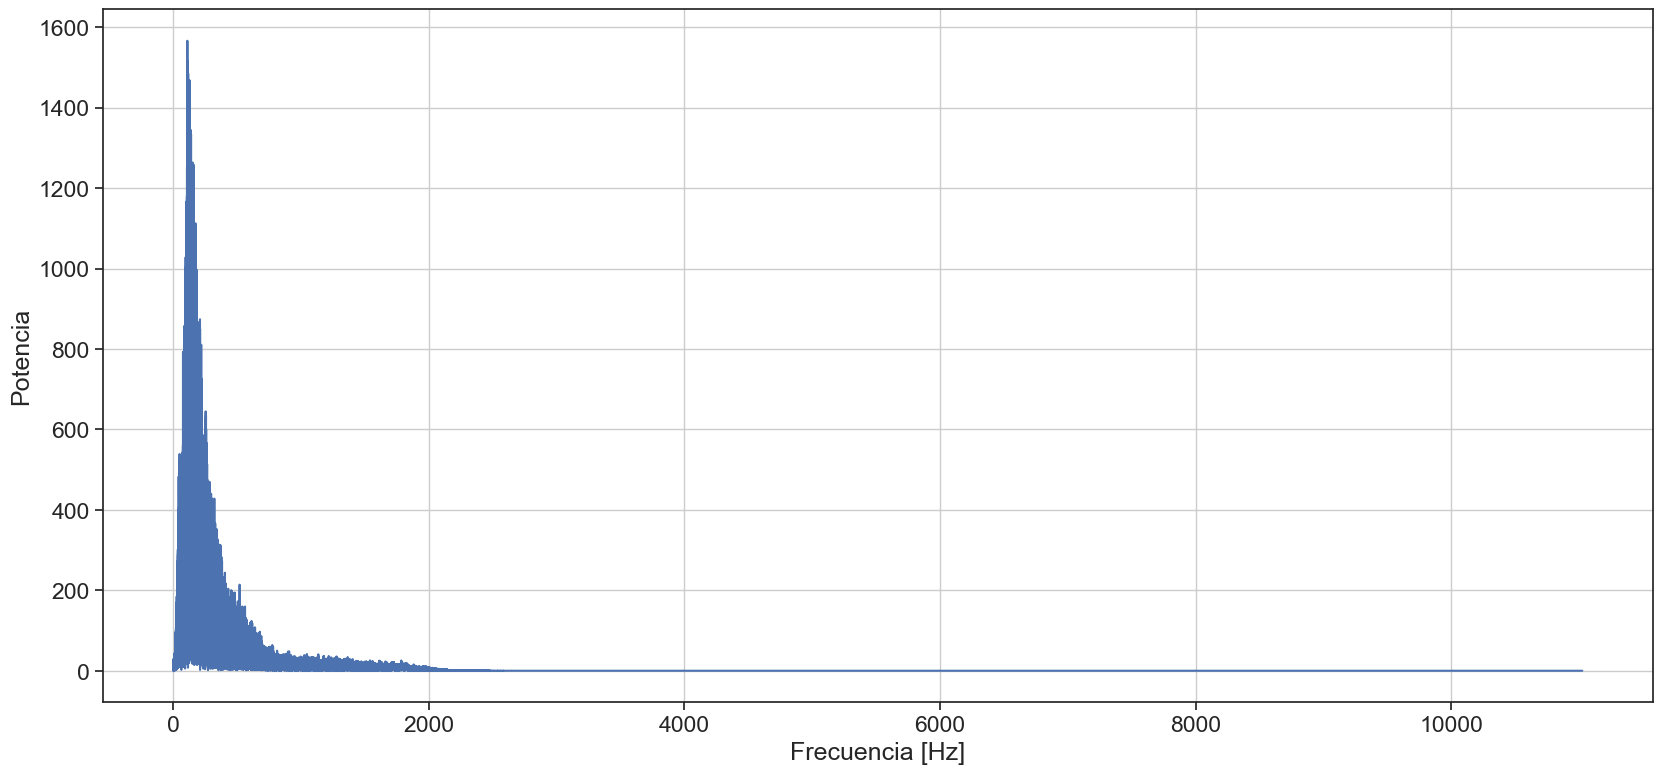

In [10]:
audio0_filter_2k = noise_filter(audio0)
plot_fft(audio0_filter_2k)

In [11]:
audio1_filter_2k = noise_filter(audio1)
audio2_filter_2k = noise_filter(audio2)

Graficamos nuevamente la señal (ahora filtrada) junto con las marcas temporales

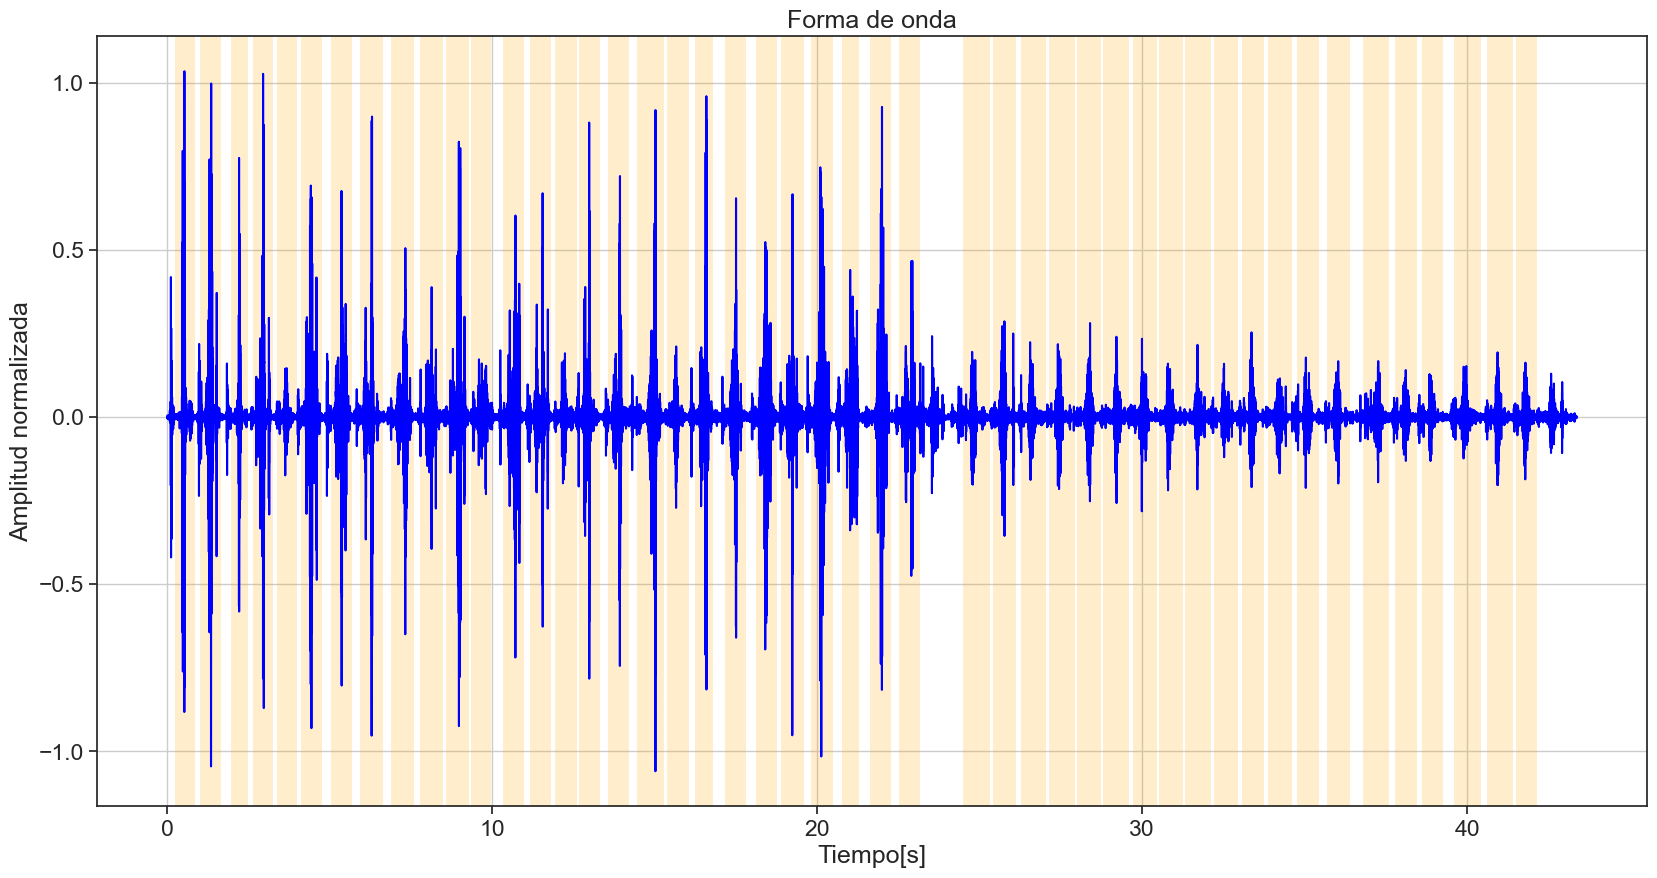

In [12]:
plot_audio(t0,audio0_filter_2k,tmarks0)

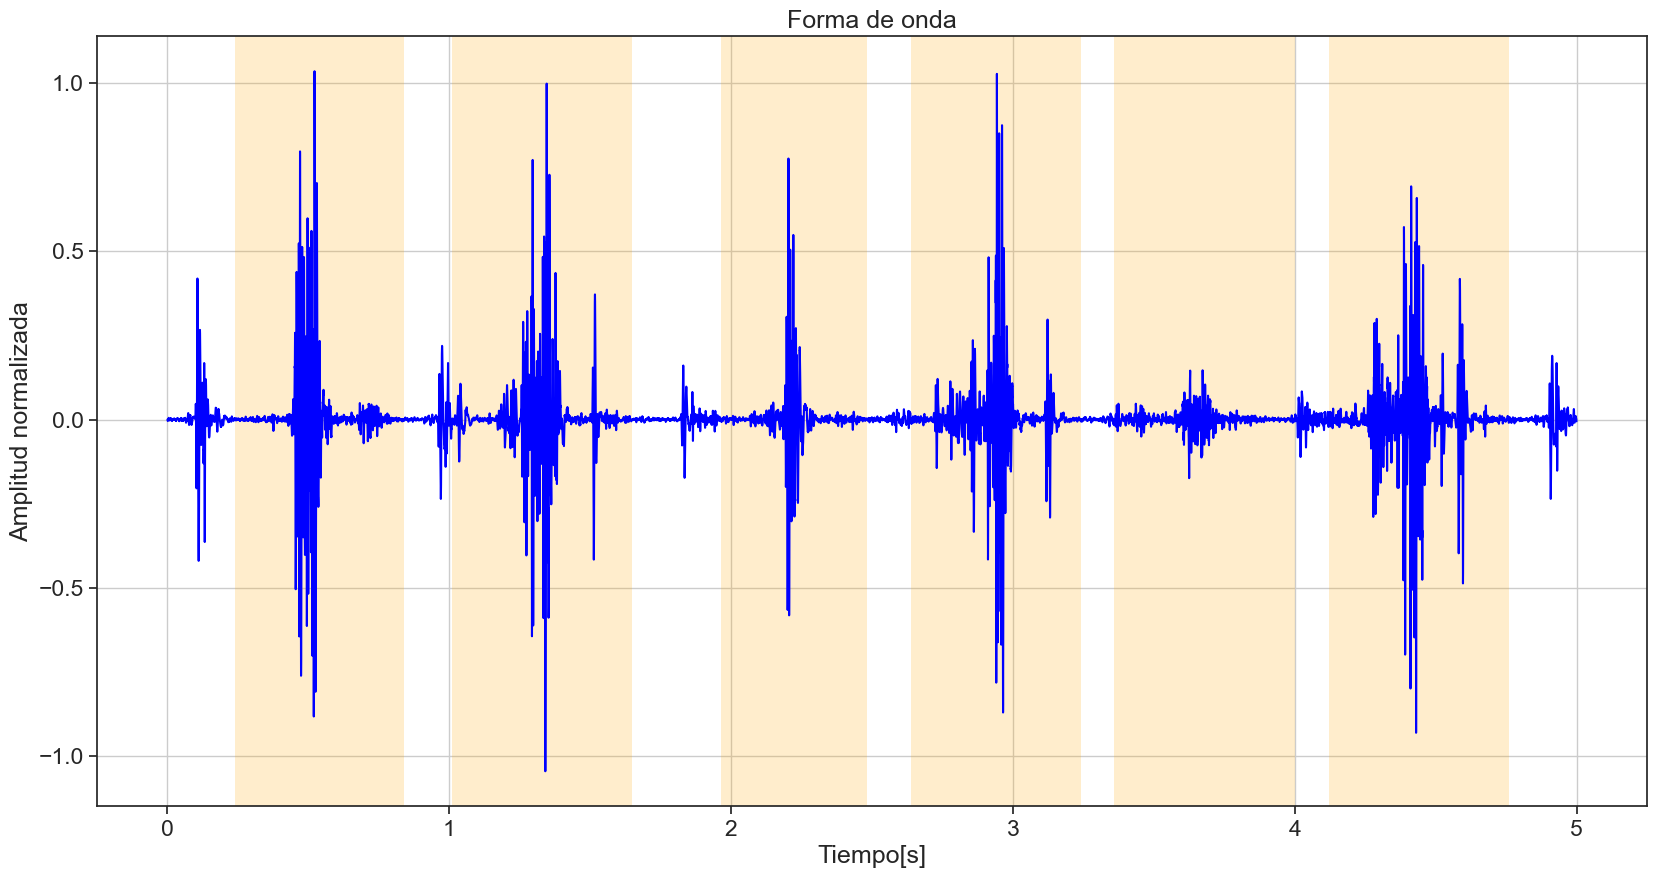

In [13]:
plot_audio(t0[:110250],audio0_filter_2k[:110250],tmarks0[:6])

Observamos que la envolvente de la señal da información de gran utilidad para la detección de los eventos. Aplicamos entonces un filtro de envolvente.

In [14]:
def envelope_filter(audio, wp=5, ws=20, gpass=3, gstop=40, freq_adq=22050):
    order, wn = buttord(wp=5, ws=20, gpass=3, gstop=40, analog=False, fs=freq_adq)
    b, a = butter(order, wn, btype='lowpass', analog=False, fs=freq_adq)
    lfilter(b, a, audio)
    return lfilter(b, a, audio)

In [15]:
audio0_envelope = envelope_filter(audio0_filter_2k**2)
audio1_envelope = envelope_filter(audio1_filter_2k**2)
audio2_envelope = envelope_filter(audio2_filter_2k**2)

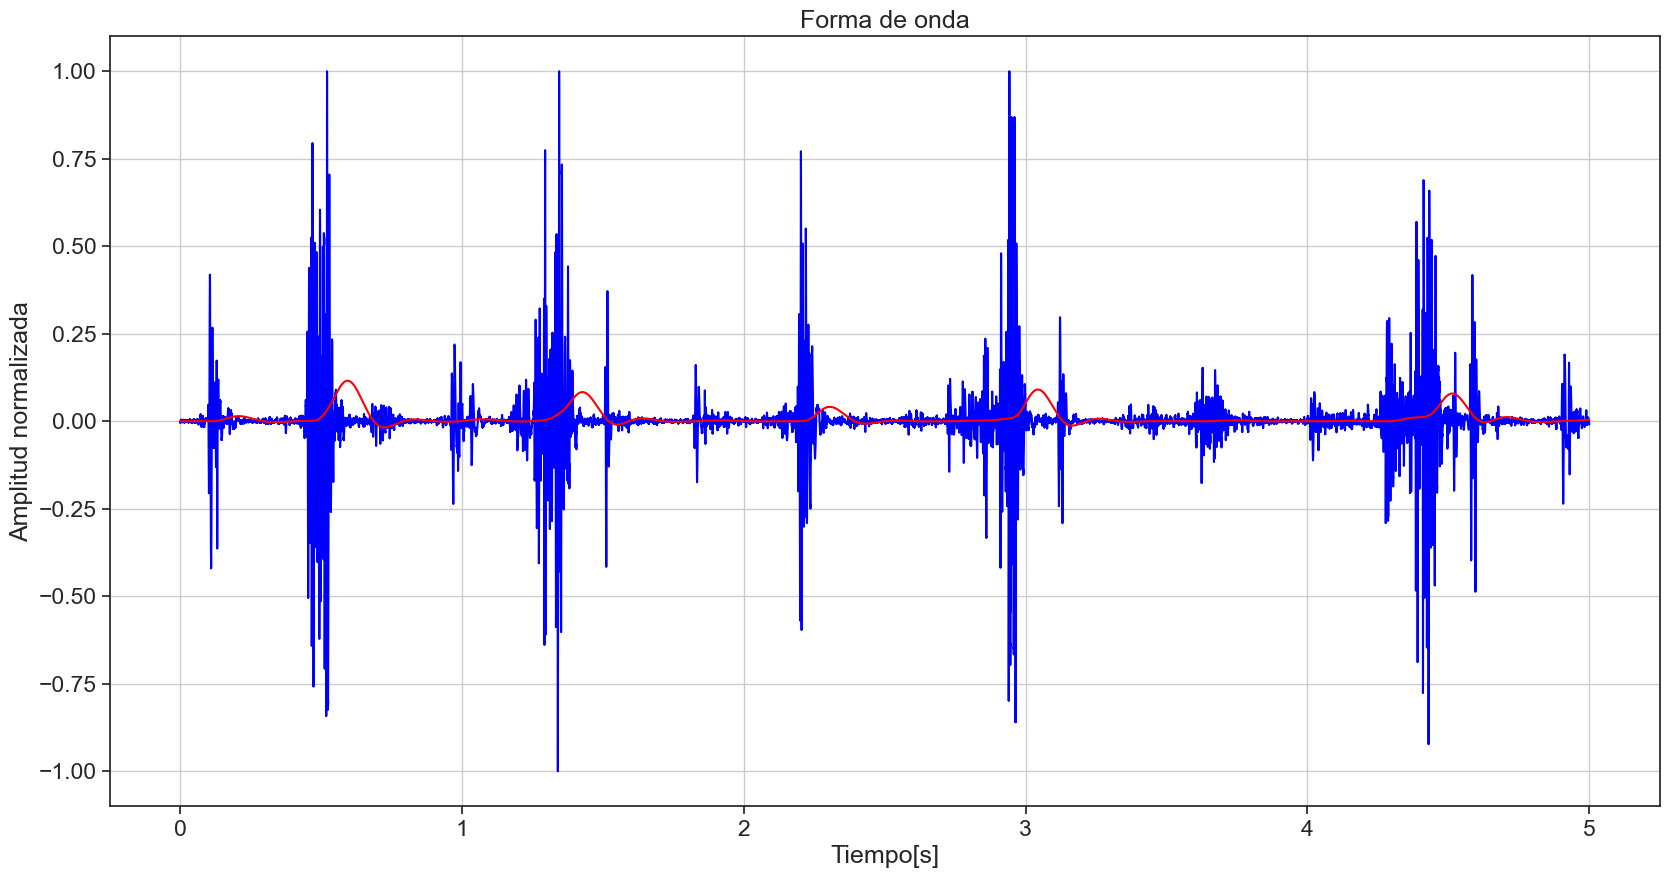

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(t0[:110250],audio0[:110250],color='blue')
plt.plot(t0[:110250],audio0_envelope[:110250],color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
plt.grid(True)
plt.show()

Observamos que el filtro funciona correctamente, aunque crea un corrimiento y una reducción en la amplitud de la señal. Dado que ahora la información util se encuentra en la banda de 0 - 5 Hz con una fstop de 20 Hz, proponemos un submuestreo de la señal de envolvente a 50 Hz, para reducir la necesidad de procesamiento posterior.

In [17]:
freq_subsample = 50

In [18]:
audio0_envelope_subsample = librosa.resample(audio0_envelope, orig_sr= freq_adq, target_sr=freq_subsample)
t0_subsample = np.array([i/freq_subsample for i in range(len(audio0_envelope_subsample))])
audio1_envelope_subsample = librosa.resample(audio1_envelope, orig_sr= freq_adq, target_sr=freq_subsample)
t1_subsample = np.array([i/freq_subsample for i in range(len(audio1_envelope_subsample))])
audio2_envelope_subsample = librosa.resample(audio2_envelope, orig_sr= freq_adq, target_sr=freq_subsample)
t2_subsample = np.array([i/freq_subsample for i in range(len(audio2_envelope_subsample))])

Para corregir el corrimiento, buscamos el valor de ajuste en forma visual. El escalado no es un problema ya que es un factor de multiplicación que puede compensarse digitalmente.

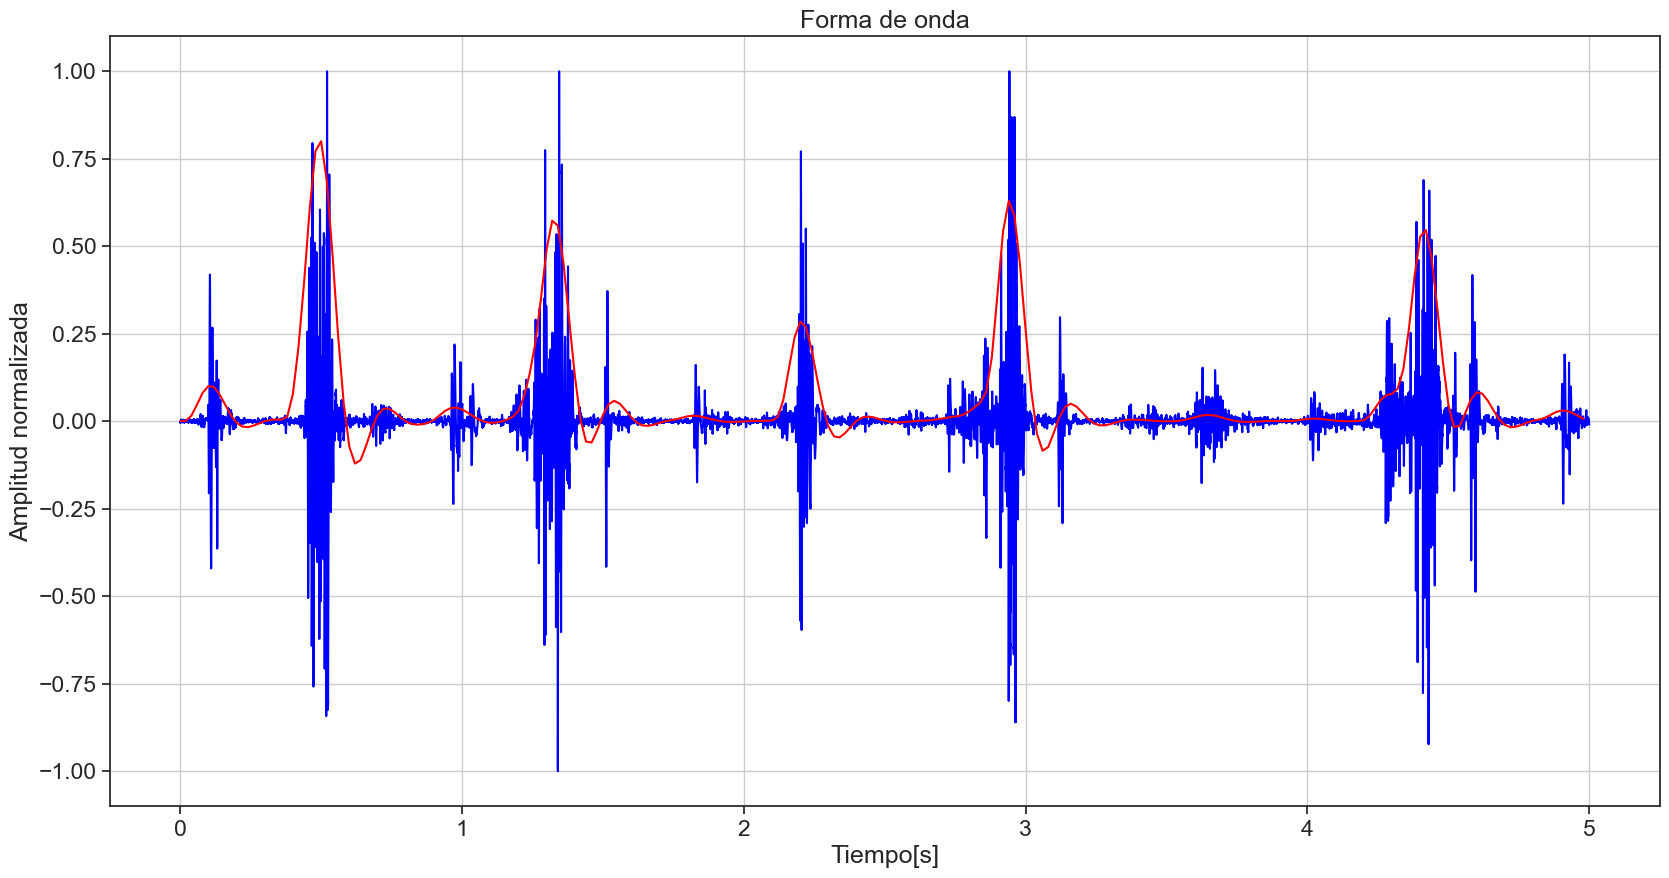

In [19]:
model_env_offset = 5

plt.figure(figsize=(20, 10))
plt.plot(t0[:110250],audio0[:110250],color='blue')
plt.plot(t0_subsample[:250],audio0_envelope_subsample[model_env_offset:250+model_env_offset]*6,color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
plt.grid(True)
plt.show()

Se busca el mejor valor umbral mediante "grid search", de manera de obtener el mayor accuracy en la cantidad de eventos detectados correctamente. Para la busqueda se utilizará audio0 y audio1, y se validará con audio2

In [20]:
def get_detection_accuracy(detection,tmarks, freq=22050):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
     # First segment
    start = 0
    end = int(np.ceil(tmarks['tstart'].iloc[0]*freq))
    if np.any(detection[start:end]):
        FP = FP + 1
    else:
        TN = TN + 1

    # Segments in between
    for idx in range(len(tmarks)):
        if idx>0:
            start = int(np.floor(tmarks['tend'].iloc[idx-1]*freq))
            end = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
            if np.any(detection[start:end]):
                FP = FP + 1
            else:
                TN = TN + 1

        start = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
        end = int(np.floor(tmarks['tend'].iloc[idx]*freq))
        if np.any(detection[start:end]):
            TP = TP +1
        else:
            FN = FN + 1

    # Last segment
    start = int(np.floor(tmarks['tend'].iloc[-1]*freq))
    end = len(detection)
    if np.any(detection[start:end]):
        FP = FP + 1
    else:
        TN = TN + 1

    return (TP + TN) / (TP + TN + FP + FN)

In [21]:
def get_thd_accuracy(audio, tmarks, thd, offset, freq=22050):
    detection = (audio >= thd) [offset:]
    return get_detection_accuracy(detection,tmarks,freq)

In [22]:
thd_opt = np.linspace(0,0.1,101)
best_param = None
best_accuracy = 0

for thd in thd_opt:
    event0_pred_accuracy = get_thd_accuracy(audio0_envelope_subsample, tmarks0, thd, model_env_offset, freq_subsample)
    event1_pred_accuracy = get_thd_accuracy(audio1_envelope_subsample, tmarks1, thd, model_env_offset, freq_subsample)
    new_accuracy = (event0_pred_accuracy + event1_pred_accuracy)/2
    if new_accuracy > best_accuracy:
        best_accuracy = new_accuracy
        best_param = thd
                    
model_env_thd = best_param

print("Mejor accuracy obtenido: " ,best_accuracy)
print("Mejor parametro de umbral: ", best_param)

Mejor accuracy obtenido:  0.8662441443923946
Mejor parametro de umbral:  0.002


In [23]:
# Validacion
event2_pred_accuracy = get_thd_accuracy(audio2_envelope_subsample, tmarks2, model_env_thd, model_env_offset, freq_subsample)
event2_pred_accuracy

0.8497854077253219

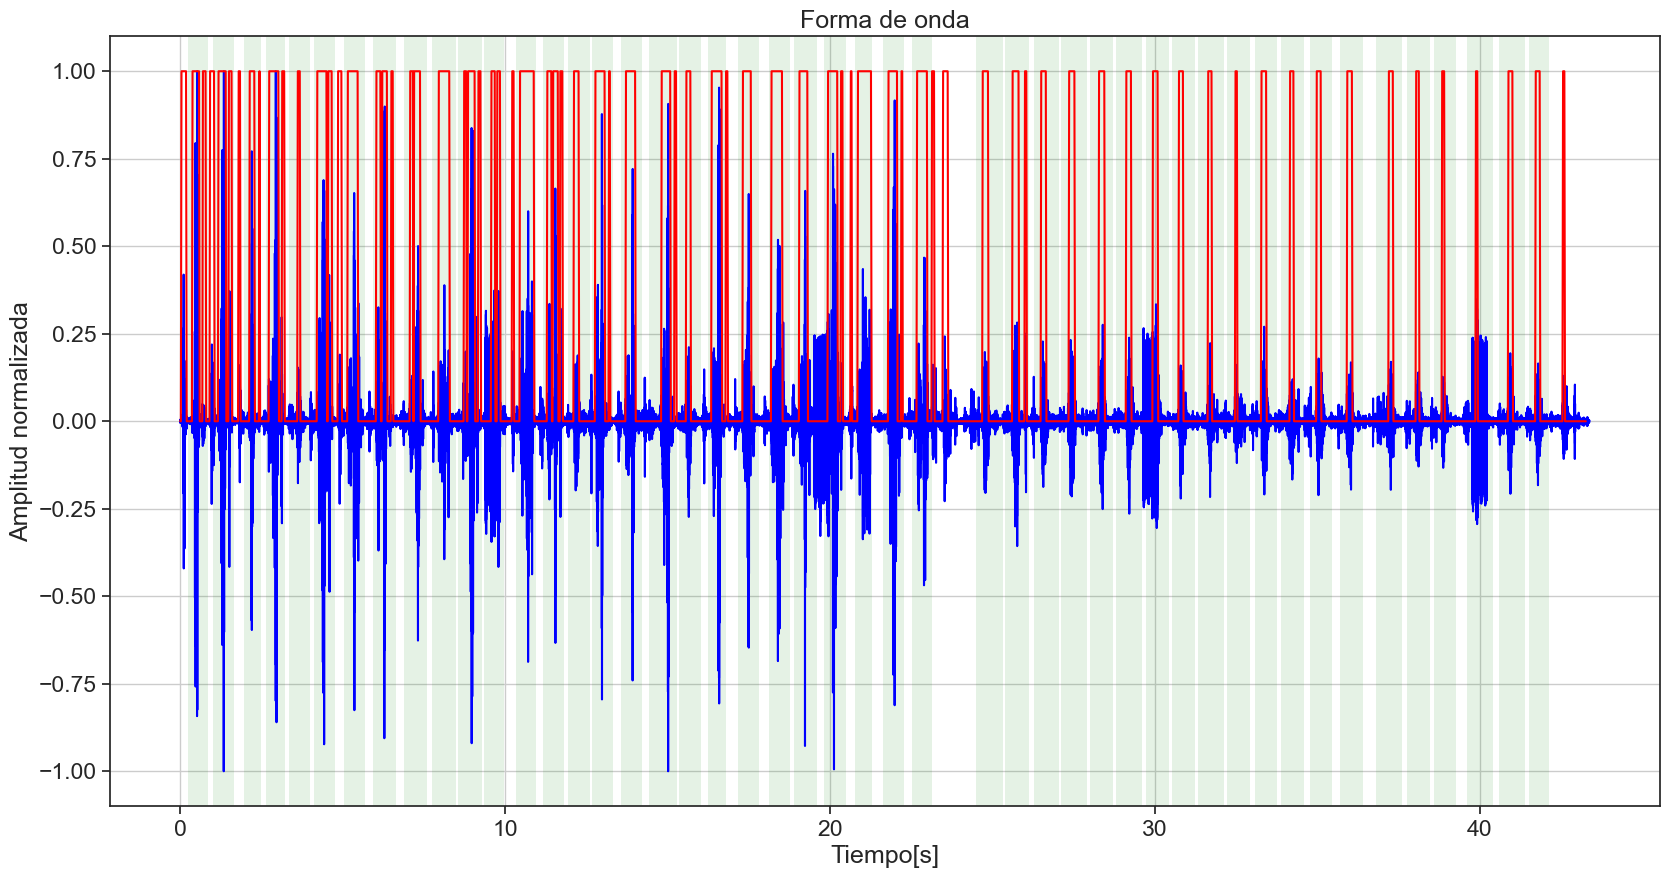

In [24]:
#Graficamos resultado
aux = (audio0_envelope_subsample> model_env_thd) [model_env_offset:]
plt.figure(figsize=(20, 10))
plt.plot(t0,audio0,color='blue')
plt.plot(t0_subsample[:-model_env_offset],aux,color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
for idx in range(len(tmarks0)):
    plt.axvspan(tmarks0['tstart'].iloc[idx], tmarks0['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
plt.grid(True)
plt.show()

Se observa mucho "rebote" en la señal. Por esto, complejizamos el modelo agregando un doble filtro antirebote (para TOn y TOff). Los tiempos los ajustamos nuevamente con grid search utilizando el accuracy como métrica.

In [25]:
def debounce_on(event, tdebounce):
    i=0
    event_debounce = np.zeros(len(event))
    i = np.nonzero(event)[0][0]
    while i<len(event):
        idx= np.nonzero(1-event[i:])[0]
        if len(idx)==0:
            break
        else:
            idx=idx[0] + i
        if (idx-i)>tdebounce:
            event_debounce[i:idx]=1  
        i = np.nonzero(event[idx:])[0]
        if len(i)==0:
            break
        else:
            i=i[0] + idx
    return event_debounce

In [26]:
def debounce_off(event, tdebounce):
    i=0
    event_debounce = np.ones(len(event))
    i = np.nonzero(1-event)[0][0]
    while i<len(event):
        idx= np.nonzero(event[i:])[0]
        if len(idx)==0:
            break
        else:
            idx=idx[0] +i
        if (idx-i)>tdebounce:
            event_debounce[i:idx]=0
        i = np.nonzero(1-event[idx:])[0]
        if len(i)==0:
            break
        else:
            i=i[0] + idx
    event_debounce[i:]=0
    return event_debounce

In [27]:
def get_ton_toff_accuracy(audio, tmarks, thd, offset, t_on, t_off, freq=22050):
    detection = (audio >= thd)[offset:]
    detection = debounce_off(debounce_on(detection,t_on*freq),t_off*freq)
    return get_detection_accuracy(detection,tmarks,freq)

In [28]:
thd_opt = np.linspace(0,0.01,11)
ton_opt = np.linspace(0,0.2,21)
toff_opt = np.linspace(0,0.2,21)
best_param = None
best_accuracy = 0

for thd in thd_opt:
    for ton in ton_opt:
        for toff in toff_opt:
            event0_pred_accuracy = get_ton_toff_accuracy(audio0_envelope_subsample, tmarks0, thd, model_env_offset, ton, toff, 
                                                         freq_subsample)
            event1_pred_accuracy = get_ton_toff_accuracy(audio1_envelope_subsample, tmarks1, thd, model_env_offset, ton, toff, 
                                                         freq_subsample)
            new_accuracy = (event0_pred_accuracy + event1_pred_accuracy)/2
            if new_accuracy > best_accuracy:
                best_accuracy = new_accuracy
                best_param = [thd, ton, toff]
                    
model_env_thd, model_ton, model_toff = best_param

print("Mejor accuracy obtenido: " , best_accuracy)
print("Mejores parametros de debounce: ", best_param)

Mejor accuracy obtenido:  0.9291540369247726
Mejores parametros de debounce:  [0.001, 0.12, 0.0]


In [29]:
# Validacion
event2_pred_accuracy = get_ton_toff_accuracy(audio2_envelope_subsample, tmarks2, model_env_thd, model_env_offset, model_ton, 
                                             model_toff, freq_subsample)
event2_pred_accuracy

0.9356223175965666

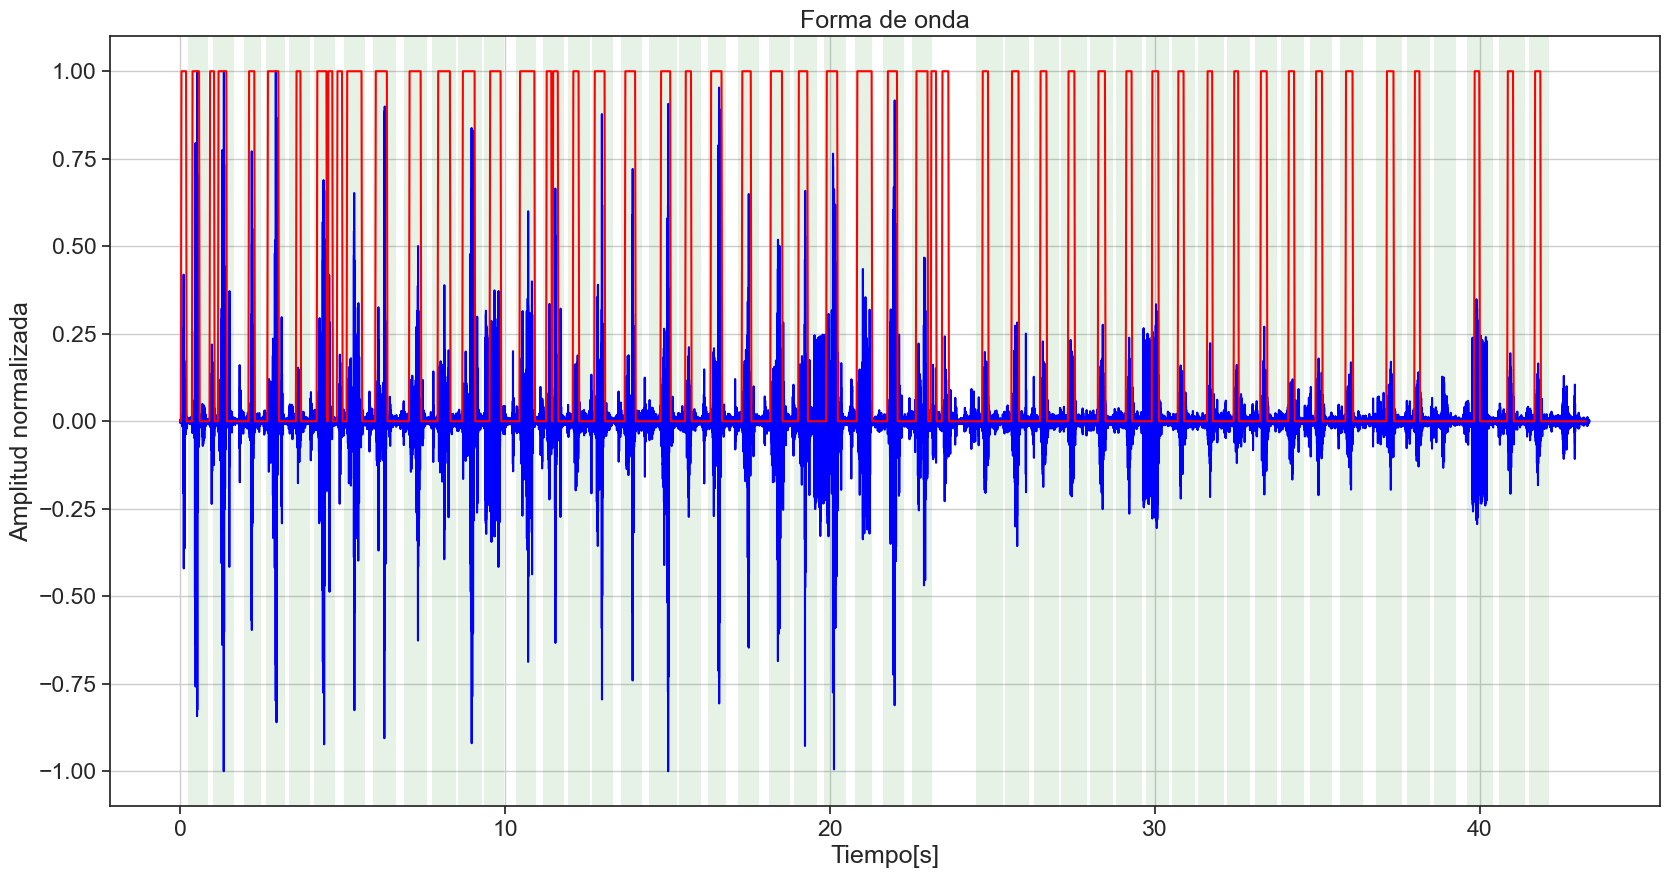

In [30]:
#Graficamos resultado
aux_det =  debounce_off(debounce_on((audio0_envelope_subsample > model_env_thd)[model_env_offset:], model_ton*freq_subsample), 
                        model_toff*freq_subsample)

plt.figure(figsize=(20, 10))
plt.plot(t0,audio0,color='blue')
plt.plot(t0_subsample[:-model_env_offset],aux_det,color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
for idx in range(len(tmarks0)):
    plt.axvspan(tmarks0['tstart'].iloc[idx], tmarks0['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
plt.grid(True)
plt.show()

Observamos un porcentaje de detección de eventos muy alto, pero los anchos de ventanas parecen ser estrechos. Podemos verificar esto calculando el coeficiente de dice.

In [31]:
def dice_coef(y_true, y_pred):
    return np.sum(y_true*y_pred)*2.0 / (np.sum(y_true) + np.sum(y_pred))

In [32]:
def tmark_to_event_detect(tmarks, final_len, freq=22050):
    detection = np.zeros(final_len)
    for idx in range(len(tmarks)):
        start = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
        end = int(np.floor(tmarks['tend'].iloc[idx]*freq))
        detection[start:end]=1
    return detection

In [33]:
def get_ton_toff_dice(audio, tmarks, thd, offset, t_on, t_off, freq=22050):
    detection = (audio >= thd)[offset:]
    detection = debounce_off(debounce_on(detection,t_on*freq),t_off*freq)
    true = tmark_to_event_detect(tmarks,len(detection),freq)
    return dice_coef(true,detection)

In [34]:
get_ton_toff_dice(audio0_envelope_subsample, tmarks0, model_env_thd, model_env_offset, model_ton, model_toff, freq_subsample)

0.5452930728241563

Para mejorar, establecemos un tiempo mínimo de evento centrado en el centro de la detección del evento. Aplicamos grid search para encontrar el valor de tiempo mínimo de ventana que produce el mayor valor del coeficiente de dice, manteniendo el accuracy.

In [35]:
def expand_window(event, t_min, freq=22050):
    idx = 0
    i=0
    det = np.copy(event)
    while i<len(event):
        i=np.nonzero(event[idx:])[0]
        if(len(i)==0):
            break
        i=i[0] + idx
        
        idx = np.nonzero((1-event)[i:])[0] 
        if(len(idx)==0):
            idx = len(event)
        else:
            idx = idx[0] + i

        if (idx-i)<(t_min*freq):
            middle = int((idx + i)/2)
            start = max( middle - int(t_min/2*freq) , 0)
            end = min (middle + int(t_min/2*freq), len(event))
            det[start:end] = 1
    return det

In [36]:
def get_tmin_accuracy_dice(event, tmarks, t_min, freq=22050):
    detection = expand_window(event,t_min, freq)
    true = tmark_to_event_detect(tmarks,len(detection),freq)
    return get_detection_accuracy(detection,tmarks, freq), dice_coef(true,detection)

In [37]:
tmin_opt = np.linspace(0,1,101)
best_param = None
best_acc = 0
best_dice = 0
best_score = 0

aux_det0 =  debounce_off(debounce_on((audio0_envelope_subsample > model_env_thd)[model_env_offset:], model_ton*freq_subsample), 
                        model_toff*freq_subsample)
aux_det1 =  debounce_off(debounce_on((audio1_envelope_subsample > model_env_thd)[model_env_offset:], model_ton*freq_subsample), 
                        model_toff*freq_subsample)

for tmin in tmin_opt:
    event0_pred_acc, event0_pred_dice = get_tmin_accuracy_dice(aux_det0, tmarks0, tmin, freq_subsample)
    event1_pred_acc, event1_pred_dice = get_tmin_accuracy_dice(aux_det1, tmarks1, tmin, freq_subsample)
    
    new_acc = (event0_pred_acc + event1_pred_acc)/2
    new_dice = (event0_pred_dice + event1_pred_dice)/2
    new_score = new_acc + new_dice
    if new_score > best_score:
        best_acc = new_acc
        best_dice = new_dice
        best_score = new_score
        best_param = [tmin]
                    
model_tmin = best_param[0]

print("Mejor accuracy obtenido: " , best_acc)
print("Mejor dice obtenido: " , best_dice)
print("Mejores parametro tiempo mínimo de ventana: ", best_param)

Mejor accuracy obtenido:  0.8793331496279967
Mejor dice obtenido:  0.7719232520141958
Mejores parametro tiempo mínimo de ventana:  [0.48]


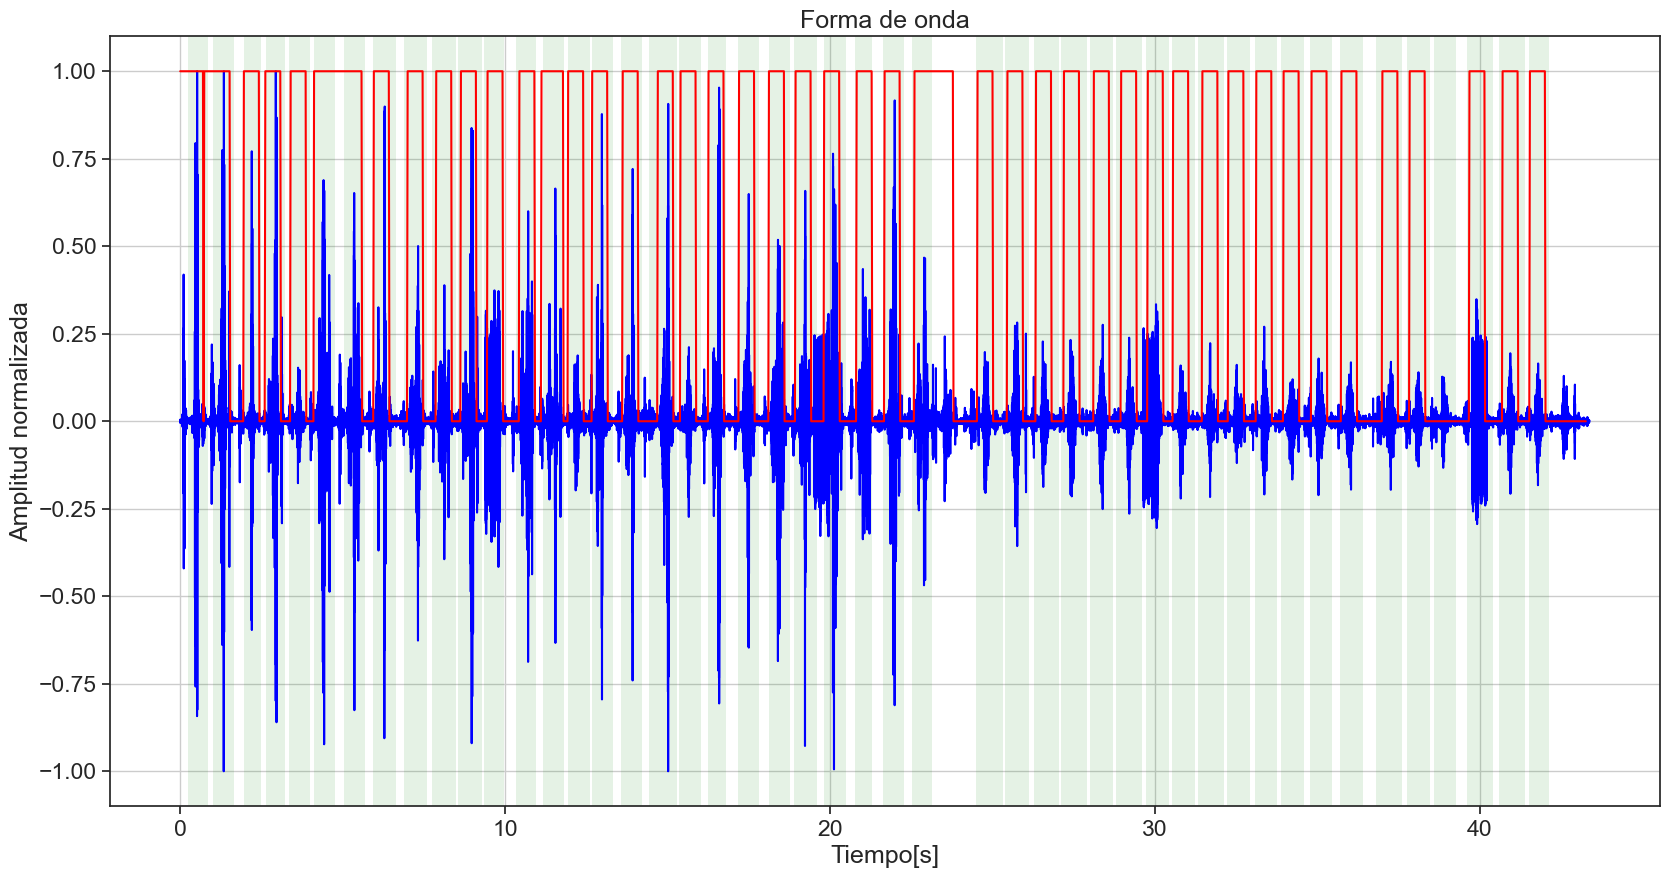

In [38]:
#Graficamos resultado
aux_det0 =  debounce_off(debounce_on((audio0_envelope_subsample > model_env_thd)[model_env_offset:], model_ton*freq_subsample), 
                        model_toff*freq_subsample)
aux_det0 = expand_window(aux_det0, model_tmin, freq_subsample)

plt.figure(figsize=(20, 10))
plt.plot(t0,audio0,color='blue')
plt.plot(t0_subsample[:-model_env_offset],aux_det0,color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
for idx in range(len(tmarks0)):
    plt.axvspan(tmarks0['tstart'].iloc[idx], tmarks0['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
plt.grid(True)
plt.show()

Aplicamos la misma lógica con el tamaño máximo de la ventana

In [39]:
def reduce_window(event, t_max, freq=22050):
    idx = 0
    i=0
    det = np.zeros(len(event))
    while i<len(event):
        
        i=np.nonzero(event[idx:])[0]
        if(len(i)==0):
            break
        i=i[0] + idx
        
        idx = np.nonzero((1-event)[i:])[0] 
        if(len(idx)==0):
            idx = len(event)
        else:
            idx = idx[0] + i

        if (idx-i)>(t_max*freq):
            middle = int((idx + i)/2)
            start = max( middle - int(t_max/2*freq) , 0)
            end = min (middle + int(t_max/2*freq), len(event))
            det[start:end] = 1
        else:
            det[i:idx] = 1
            
    return det

In [40]:
def get_tmax_accuracy_dice(event, tmarks, t_max, freq=22050):
    detection = reduce_window(event,t_max,freq)
    true = tmark_to_event_detect(tmarks,len(detection),freq)
    return get_detection_accuracy(detection,tmarks, freq), dice_coef(true,detection)

In [41]:
tmax_opt = np.linspace(0,2,201)
best_param = None
best_acc = 0
best_dice = 0
best_score = 0

aux_det0 =  expand_window(debounce_off(debounce_on((audio0_envelope_subsample > model_env_thd)[model_env_offset:], 
                                                model_ton*freq_subsample), model_toff*freq_subsample), model_tmin, 
                          freq_subsample) 
aux_det1 =  expand_window(debounce_off(debounce_on((audio1_envelope_subsample > model_env_thd)[model_env_offset:], 
                                                model_ton*freq_subsample), model_toff*freq_subsample), model_tmin, 
                          freq_subsample)

for tmax in tmax_opt:
    event0_pred_acc, event0_pred_dice = get_tmax_accuracy_dice(aux_det0, tmarks0, tmax, freq_subsample)
    event1_pred_acc, event1_pred_dice = get_tmax_accuracy_dice(aux_det1, tmarks1, tmax, freq_subsample)
    
    new_acc = (event0_pred_acc + event1_pred_acc)/2
    new_dice = (event0_pred_dice + event1_pred_dice)/2
    new_score = new_acc + new_dice
    if new_score > best_score:
        best_acc = new_acc
        best_dice = new_dice
        best_score = new_score
        best_param = [tmax]
                    
model_tmax = best_param[0]

print("Mejor accuracy obtenido: " , best_acc)
print("Mejor dice obtenido: " , best_dice)
print("Mejor parámetro de tiempo máximo de ventana: ", best_param)

Mejor accuracy obtenido:  0.8793331496279967
Mejor dice obtenido:  0.7719232520141958
Mejor parámetro de tiempo máximo de ventana:  [1.48]


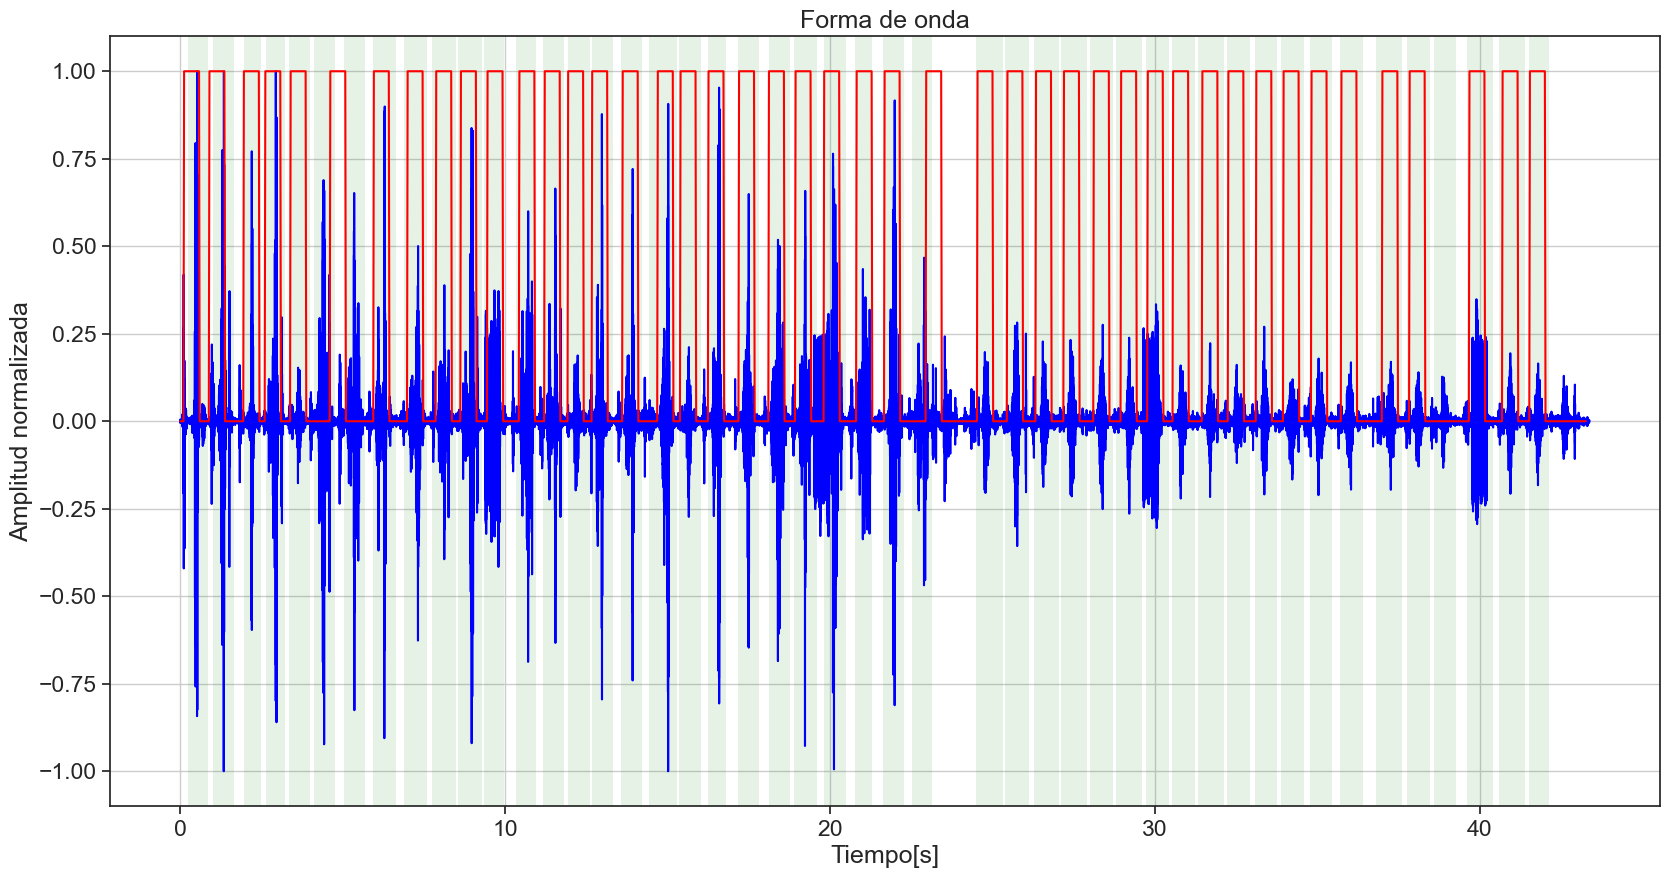

In [42]:
#Graficamos resultado
aux_det0 =  debounce_off(debounce_on((audio0_envelope_subsample > model_env_thd)[model_env_offset:], model_ton*freq_subsample), 
                        model_toff*freq_subsample)
aux_det0 = expand_window(aux_det0,model_tmin,freq_subsample)
aux_det0 = reduce_window(aux_det0,model_tmin,freq_subsample)

plt.figure(figsize=(20, 10))
plt.plot(t0,audio0,color='blue')
plt.plot(t0_subsample[:-model_env_offset],aux_det0,color='red')
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud normalizada")
plt.title("Forma de onda")
for idx in range(len(tmarks0)):
    plt.axvspan(tmarks0['tstart'].iloc[idx], tmarks0['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
plt.grid(True)
plt.show()

Resumimos todo el análisis anterior en clases que engloban el modelo de detección de eventos

In [115]:
class EnvelopeFilter:
    
    def __init__(self, freq, freq_resample):
        self.freq = freq
        self.freq_resample = freq_resample
        self.env_offset = int(freq_resample/10)
    
    def noise_filter(self, audio, wp=2000, ws=2500, gpass=3, gstop=40):
        order, wn = buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=self.freq)
        b, a = butter(order, wn, btype='lowpass', analog=False, fs=self.freq)
        return lfilter(b, a, audio)
    
    
    def envelope_filter(self, audio, wp=5, ws=20, gpass=3, gstop=40):
        order, wn = buttord(wp=5, ws=20, gpass=3, gstop=40, analog=False, fs=self.freq)
        b, a = butter(order, wn, btype='lowpass', analog=False, fs=self.freq)
        lfilter(b, a, audio)
        return lfilter(b, a, audio)
    
    def fit(self, audio):
        aux = audio
        aux = self.noise_filter(aux)
        aux = self.envelope_filter(aux**2)
        return librosa.resample(aux, orig_sr= self.freq, target_sr=self.freq_resample)[self.env_offset:]

In [44]:
class DetectionAccuracy:

    @staticmethod
    def fit(detection, tmarks, freq):
        TP = 0
        TN = 0
        FP = 0
        FN = 0

         # First segment
        start = 0
        end = int(np.ceil(tmarks['tstart'].iloc[0]*freq))
        if np.any(detection[start:end]):
            FP = FP + 1
        else:
            TN = TN + 1

        # Segments in between
        for idx in range(len(tmarks)):
            if idx>0:
                start = int(np.floor(tmarks['tend'].iloc[idx-1]*freq))
                end = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
                if np.any(detection[start:end]):
                    FP = FP + 1
                else:
                    TN = TN + 1

            start = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
            end = int(np.floor(tmarks['tend'].iloc[idx]*freq))
            if np.any(detection[start:end]):
                TP = TP +1
            else:
                FN = FN + 1

        # Last segment
        start = int(np.floor(tmarks['tend'].iloc[-1]*freq))
        end = len(detection)
        if np.any(detection[start:end]):
            FP = FP + 1
        else:
            TN = TN + 1

        return (TP + TN) / (TP + TN + FP + FN)

In [45]:
class DiceCoef:
    
    @staticmethod
    def fit(detection, tmarks, freq):
        y_true = np.zeros(len(detection))
        for idx in range(len(tmarks)):
            start = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
            end = int(np.floor(tmarks['tend'].iloc[idx]*freq))
            y_true[start:end]=1
    
        y_pred = detection
        return np.sum(y_true*y_pred)*2.0 / (np.sum(y_true) + np.sum(y_pred))
    

In [46]:
class DebounceThdGridSearch:
    
    def __init__(self, freq):
        self.freq = freq

        
    def debounce_on(self, event, tdebounce):
        i=0
        event_debounce = np.zeros(len(event))
        i = np.nonzero(event)[0][0]
        while i<len(event):
            idx= np.nonzero(1-event[i:])[0]
            if len(idx)==0:
                break
            else:
                idx=idx[0] + i
            if (idx-i)>tdebounce:
                event_debounce[i:idx]=1  
            i = np.nonzero(event[idx:])[0]
            if len(i)==0:
                break
            else:
                i=i[0] + idx
        return event_debounce
    
    
    def debounce_off(self, event, tdebounce):
        i=0
        event_debounce = np.ones(len(event))
        i = np.nonzero(1-event)[0][0]
        while i<len(event):
            idx= np.nonzero(event[i:])[0]
            if len(idx)==0:
                break
            else:
                idx=idx[0] +i
            if (idx-i)>tdebounce:
                event_debounce[i:idx]=0
            i = np.nonzero(1-event[idx:])[0]
            if len(i)==0:
                break
            else:
                i=i[0] + idx
        event_debounce[i:]=0
        return event_debounce
    
    
    def get_ton_toff_metric(self, envelope, tmarks, thd, t_on, t_off):
        detection = (envelope >= thd)
        detection = self.debounce_off(self.debounce_on(detection,t_on*self.freq),t_off*self.freq)
        return DetectionAccuracy.fit(detection, tmarks, self.freq)
    
    
    def fit(self, envelopes, tmarks, thd_opt = np.linspace(0,0.01,11), ton_opt = np.linspace(0,0.2,21), 
            toff_opt = np.linspace(0,0.2,21)):
        best_param = None
        best_score = 0

        for thd in thd_opt:
            for ton in ton_opt:
                for toff in toff_opt:
                    score = 0
                    for i in range(len(envelopes)):
                        score = score + self.get_ton_toff_metric(envelopes[i], tmarks[i], thd, ton, toff)
                    new_score = score / len(envelopes)
                    if new_score > best_score:
                        best_score = new_score
                        best_param = [thd, ton, toff]

        self.model_thd, self.model_ton, self.model_toff = best_param
        self.best_score = best_score 
        return best_score
        
        
    def predict(self,envelopes):
        if isinstance(envelopes,list):
            detections = []
            for i in range(len(envelopes)):
                detection = (envelopes[i] >= self.model_thd)
                detection = self.debounce_off(self.debounce_on(detection,self.model_ton*self.freq),self.model_toff*self.freq)
                detections.append(detection)
        else:
            detections = (envelopes >= self.model_thd)
            detections = self.debounce_off(self.debounce_on(detections,self.model_ton*self.freq),self.model_toff*self.freq)
        
        return detections

In [71]:
class ExpandReduceGridSearch:
    
    def __init__(self, freq):
        self.freq = freq
    
    
    def expand_window(self, event, t_min):
        idx = 0
        i=0
        det = np.copy(event)
        while i<len(event):
            i=np.nonzero(event[idx:])[0]
            if(len(i)==0):
                break
            i=i[0] + idx

            idx = np.nonzero((1-event)[i:])[0] 
            if(len(idx)==0):
                idx = len(event)
            else:
                idx = idx[0] + i

            if (idx-i)<(t_min*self.freq):
                middle = int((idx + i)/2)
                start = max( middle - int(t_min/2*self.freq) , 0)
                end = min (middle + int(t_min/2*self.freq), len(event))
                det[start:end] = 1
        return det
    
    
    def reduce_window(self, event, t_max):
        idx = 0
        i=0
        det = np.zeros(len(event))
        while i<len(event):

            i=np.nonzero(event[idx:])[0]
            if(len(i)==0):
                break
            i=i[0] + idx

            idx = np.nonzero((1-event)[i:])[0] 
            if(len(idx)==0):
                idx = len(event)
            else:
                idx = idx[0] + i

            if (idx-i)>(t_max*self.freq):
                middle = int((idx + i)/2)
                start = max( middle - int(t_max/2*self.freq) , 0)
                end = min (middle + int(t_max/2*self.freq), len(event))
                det[start:end] = 1
            else:
                det[i:idx] = 1

        return det
    
    
    def get_tmin_metric(self, event, tmarks, t_min):
        detection = self.expand_window(event,t_min)
        return DetectionAccuracy.fit(detection, tmarks, self.freq) + DiceCoef.fit(detection, tmarks, self.freq)
    
    
    def get_tmax_metric(self, event, tmarks, t_max):
        detection = self.reduce_window(event,t_max)
        return DetectionAccuracy.fit(detection, tmarks, self.freq) + DiceCoef.fit(detection, tmarks, self.freq)
    
    
    def fit(self, events, tmarks, tmin_opt = np.linspace(0.01,1,100), tmax_opt = np.linspace(0.01,2,200)):
        
        best_score = 0
        for tmin in tmin_opt:
            score = 0
            for i in range(len(events)):
                score = score + self.get_tmin_metric(events[i], tmarks[i], tmin)
            new_score = score / len(events)
            if new_score > best_score:
                best_score = new_score
                best_tmin = tmin
        self.model_tmin = best_tmin
        
        aux = []
        for i in range(len(events)):
            aux.append(self.expand_window(events[i],self.model_tmin))
        best_score=0
        for tmax in tmax_opt:
            score = 0
            for i in range(len(aux)):
                score = score + self.get_tmax_metric(aux[i], tmarks[i], tmax)
            new_score = score / len(aux)
            if new_score > best_score:
                best_score = new_score
                best_tmax = tmax
        self.model_tmax = best_tmax
        self.best_score = best_score
        
        return best_score
    
    
    def predict(self,events):
        if isinstance(events,list):
            detections = []
            for i in range(len(events)):
                detection = self.reduce_window(self.expand_window(events[i],self.model_tmin),self.model_tmax)
                detections.append(detection)
        else:
            detections = self.reduce_window(self.expand_window(events,self.model_tmin),self.model_tmax)
        
        return detections
    

In [72]:
class EventDetectionModel:
    
    def __init__(self, freq=22050, freq_resample=50):
        self.freq = freq
        self.freq_resample = freq_resample
        self.envelope_filter = EnvelopeFilter(self.freq, freq_resample)
        self.debounceThdGridSearch = DebounceThdGridSearch(self.freq_resample)
        self.debounceThdGridSearch = DebounceThdGridSearch(self.freq_resample)
        self.expandReduceGridSearch = ExpandReduceGridSearch(self.freq_resample)
            
            
    def load_file(self, path):
         # Read file to get buffer
        ifile = wave.open(path+".wav")
        samples = ifile.getnframes()
        audio = ifile.readframes(samples)
        # Convert buffer to float32 using NumPy                                                                                 
        audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
        audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
        # Normalize float32 array so that values are between -1.0 and +1.0                                                      
        max_int16 = 2**15
        audio_normalized = audio_as_np_float32 / max_int16
        timestamp_audio = np.arange(audio_normalized.shape[0])/self.freq
        df_marks = pd.read_csv(path+".txt", sep="\t", header=None, names= ['tstart','tend','class'])
        
        return timestamp_audio,audio_normalized, df_marks
    
    
    def preprocessing(self, audio):
        envelope = []
        for i in range(len(audio)):
            aux = audio[i]
            envelope.append(self.envelope_filter.fit(aux))
        return envelope
    
    
    def fit(self, files):
        # Load data
        audio_train = []
        tmarks_train = []
        for filename in files:
            t, audio, tmark = self.load_file(filename)
            audio_train.append(audio)
            tmarks_train.append(tmark)
            
        # Preprocessing
        envelope_train = self.preprocessing(audio_train)
        
        # Fit parameters
        self.debounceThdGridSearch.fit(envelope_train, tmarks_train)
        aux = self.debounceThdGridSearch.predict(envelope_train)
        self.expandReduceGridSearch.fit(aux, tmarks_train)
        
        
    def predict(self, files):
         # Load data
        audio_test = []
        tmarks_test = []
        for filename in files:
            t, audio, tmark = self.load_file(filename)
            audio_test.append(audio)
            
        # Preprocessing
        envelope_test = self.preprocessing(audio_test)
        
        # Predict
        aux = self.debounceThdGridSearch.predict(envelope_test)
        detection = self.expandReduceGridSearch.predict(aux)
        
        return detection
    
            
    def test(self, files):
        # Load data
        audio_test = []
        tmarks_test = []
        for filename in files:
            t, audio, tmark = self.load_file(filename)
            audio_test.append(audio)
            tmarks_test.append(tmark)
            
        # Preprocessing
        envelope_test = self.preprocessing(audio_test)
        
        # Predict
        aux = self.debounceThdGridSearch.predict(envelope_test)
        detection = self.expandReduceGridSearch.predict(aux)
        
        accuracy = 0
        dice = 0
        
        for i in range(len(detection)):
            accuracy = accuracy + DetectionAccuracy.fit(detection[i], tmarks_test[i], self.freq_resample)
            dice = dice + DiceCoef.fit(detection[i], tmarks_test[i], self.freq_resample)
        
        return [accuracy/len(detection), dice/len(detection)]
        

In [73]:
train_files =["./Audios/Detección de eventos masticatorios/recording_01",
              "./Audios/Detección de eventos masticatorios/recording_51"]

test_files =['./Audios/Detección de eventos masticatorios/recording_52']

event_detection_model = EventDetectionModel()
event_detection_model.fit(train_files)
train_score = event_detection_model.test(train_files)
test_score = event_detection_model.test(test_files)
print("Score entrenamiento: ", train_score)
print("Score test: ", test_score)

Score entrenamiento:  [0.8793331496279967, 0.7719232520141958]
Score test:  [0.9184549356223176, 0.8239456552504953]


-------------------------------------------------------------------------------------------------------------------------------

## Clasificacion de eventos

Para la clasificacion de eventos, entrenaremos inicialmente con archivos de audio separados y luego aplicaremos sobre los audios utilizados anteriormente para verificar.

In [99]:
def load_classification_files(file_path):
    filename = "train_labels.csv"
    train_labels = pd.read_csv(file_path + filename, sep=",")
    
    file_path = file_path= file_path + "data/"
    x_filtered_data = np.zeros(shape=(len(train_labels),int(0.8*freq_adq)))
    x_envelope_data = np.zeros(shape=(len(train_labels),int(0.8*freq_adq)-2025)) 
    for idx in range(len(train_labels)):
        filename = str(train_labels['filename'].iloc[idx]).rjust(4,"0") + ".wav"
        ifile = wave.open(file_path+filename)
        samples = ifile.getnframes()
        audio = ifile.readframes(samples)
        # Convert buffer to float32 using NumPy                                                                                 
        audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
        audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
        # Normalize float32 array so that values are between -1.0 and +1.0                                                      
        max_int16 = 2**15
        x_temp = noise_filter(audio_as_np_float32 / max_int16)**2
        x_filtered_data[idx,:] = x_temp
        x_envelope_data[idx,:] = envelope_filter(x_temp)[2025:]
        
    return x_envelope_data, x_filtered_data, train_labels

In [100]:
x_envelope, x_filtered, train_labels = load_classification_files ("Audios/Clasificacion eventos/")

In [101]:
train_labels

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2
...,...,...,...,...
1527,3073,fescue,tall,1
1528,3075,fescue,tall,1
1529,3077,fescue,tall,1
1530,3079,fescue,tall,1


In [102]:
y_dict = {0:'bite', 1:'chew', 2:'chewbite'}
y_clasif = np.array(train_labels['label'])

Hacemos un plot de la forma de onda de cada tipo de evento

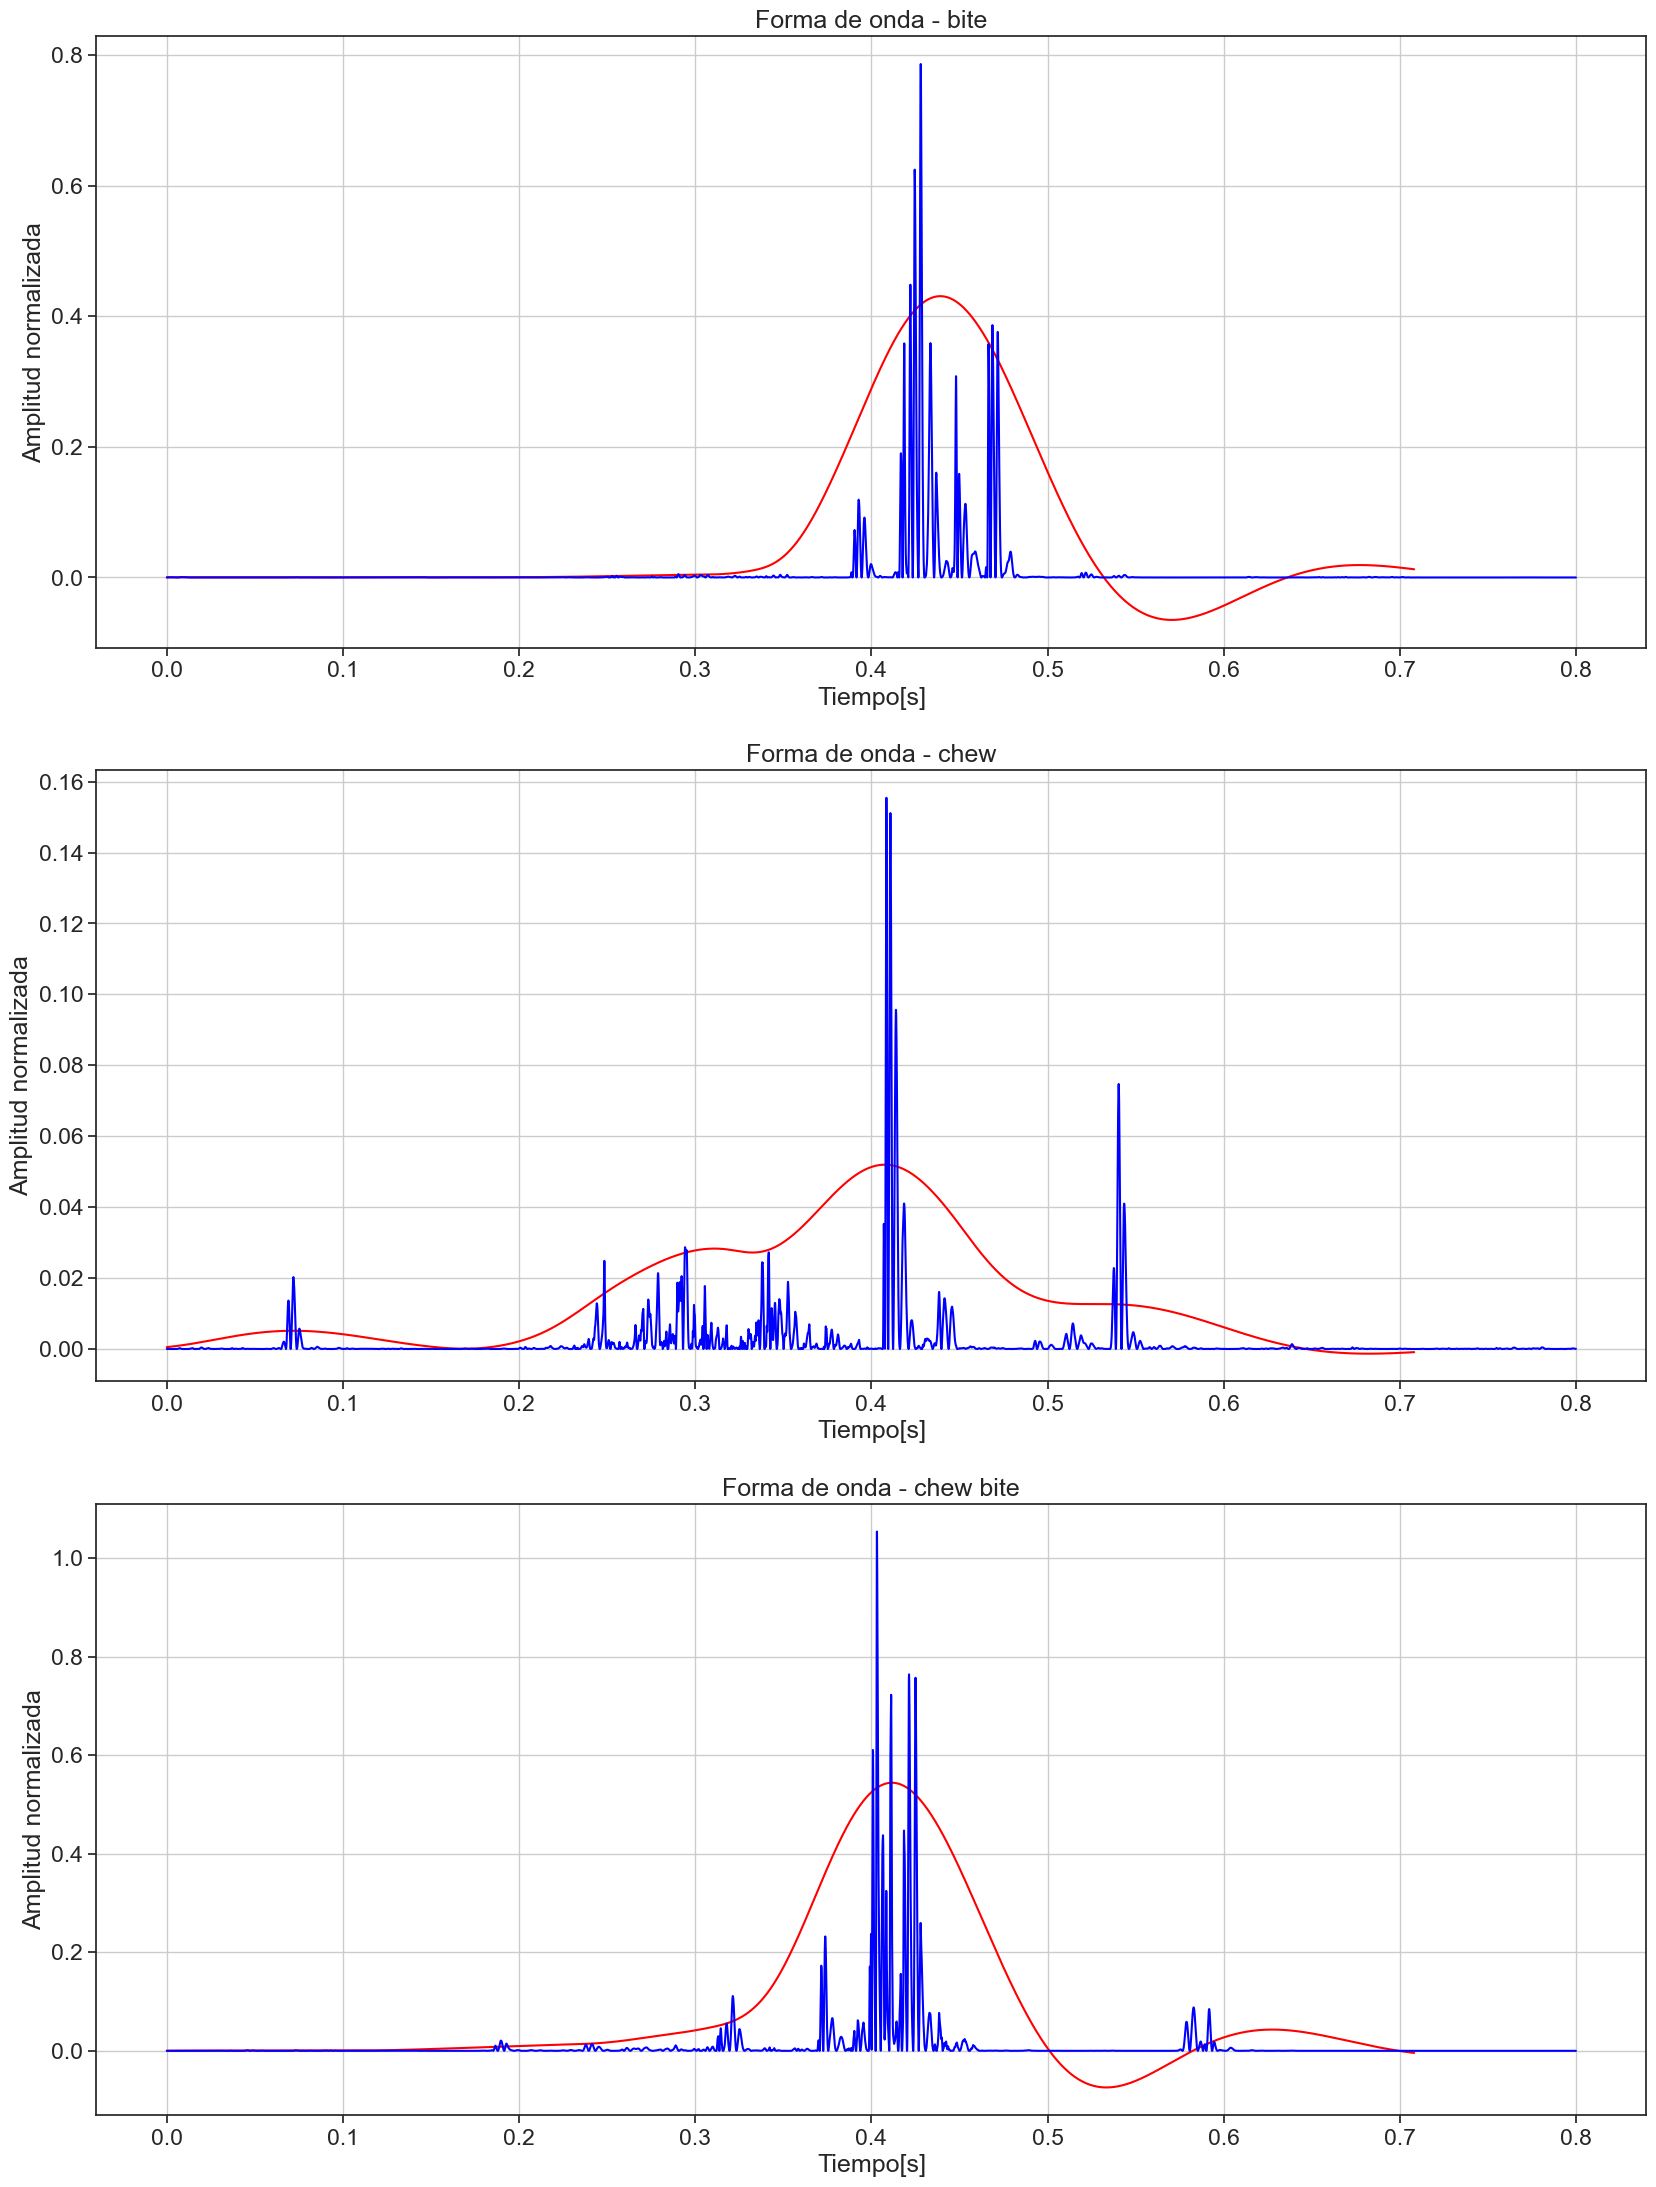

In [103]:
fig, axs = plt.subplots(3, 1, figsize=(20,27))
bite_idx = np.argwhere(y_clasif==0)[0][0]
axs[0].plot([i/freq_adq for i in range(len(x_envelope[bite_idx]))],x_envelope[bite_idx]*6,color='red')
axs[0].plot([i/freq_adq for i in range(len(x_filtered[bite_idx]))],x_filtered[bite_idx],color='blue')
axs[0].set_xlabel("Tiempo[s]")
axs[0].set_ylabel("Amplitud normalizada")
axs[0].set_title("Forma de onda - bite")
axs[0].grid(True)
chew_idx = np.argwhere(y_clasif==1)[0][0]
axs[1].plot([i/freq_adq for i in range(len(x_envelope[chew_idx]))],x_envelope[chew_idx]*6,color='red')
axs[1].plot([i/freq_adq for i in range(len(x_filtered[chew_idx]))],x_filtered[chew_idx],color='blue')
axs[1].set_xlabel("Tiempo[s]")
axs[1].set_ylabel("Amplitud normalizada")
axs[1].set_title("Forma de onda - chew")
axs[1].grid(True)
chewbite_idx = np.argwhere(y_clasif==2)[0][0]
axs[2].plot([i/freq_adq for i in range(len(x_envelope[chewbite_idx]))],x_envelope[chewbite_idx]*6,color='red')
axs[2].plot([i/freq_adq for i in range(len(x_filtered[chewbite_idx]))],x_filtered[chewbite_idx],color='blue')
axs[2].set_xlabel("Tiempo[s]")
axs[2].set_ylabel("Amplitud normalizada")
axs[2].set_title("Forma de onda - chew bite")
axs[2].grid(True)
plt.show()

En principo las gráficas se ven muy similares. Por esto haremos un ploteo de todas las formas de onda por cada evento, para identificar si a priori estos son distinguibles a simple vista

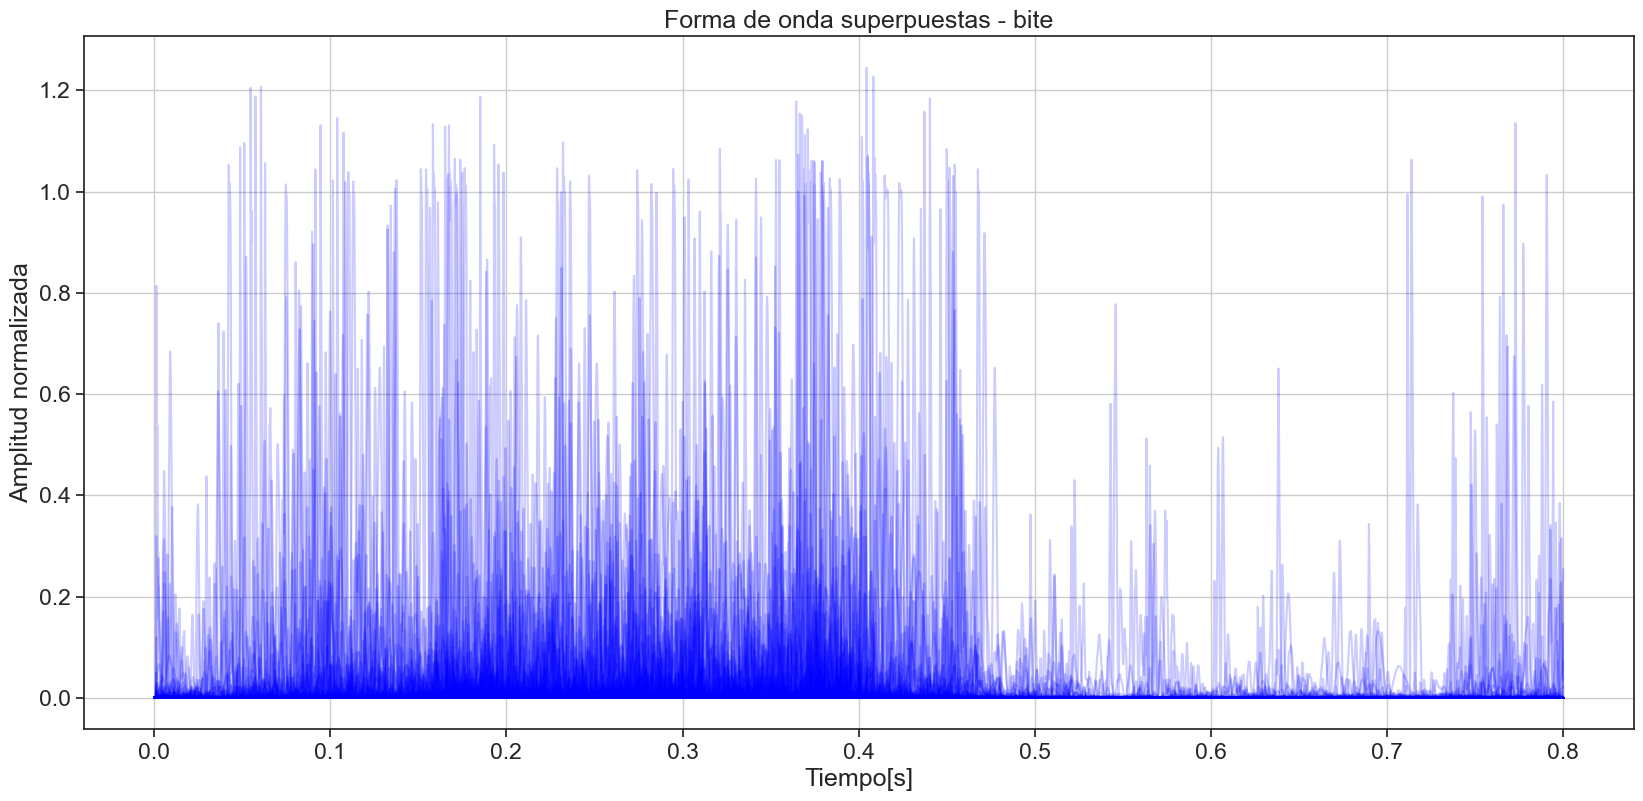

In [104]:
# Ploteamos todas las graficas de bite superpuestas
fig, ax = plt.subplots(1, 1)
bite_idxs = np.nonzero(y_clasif==0)[0]
for idx in bite_idxs:
    ax.plot([i/freq_adq for i in range(len(x_filtered[idx]))],x_filtered[idx],color='blue', alpha= 0.2)
ax.set_xlabel("Tiempo[s]")
ax.set_ylabel("Amplitud normalizada")
ax.set_title("Forma de onda superpuestas - bite")
ax.grid(True)
plt.show()

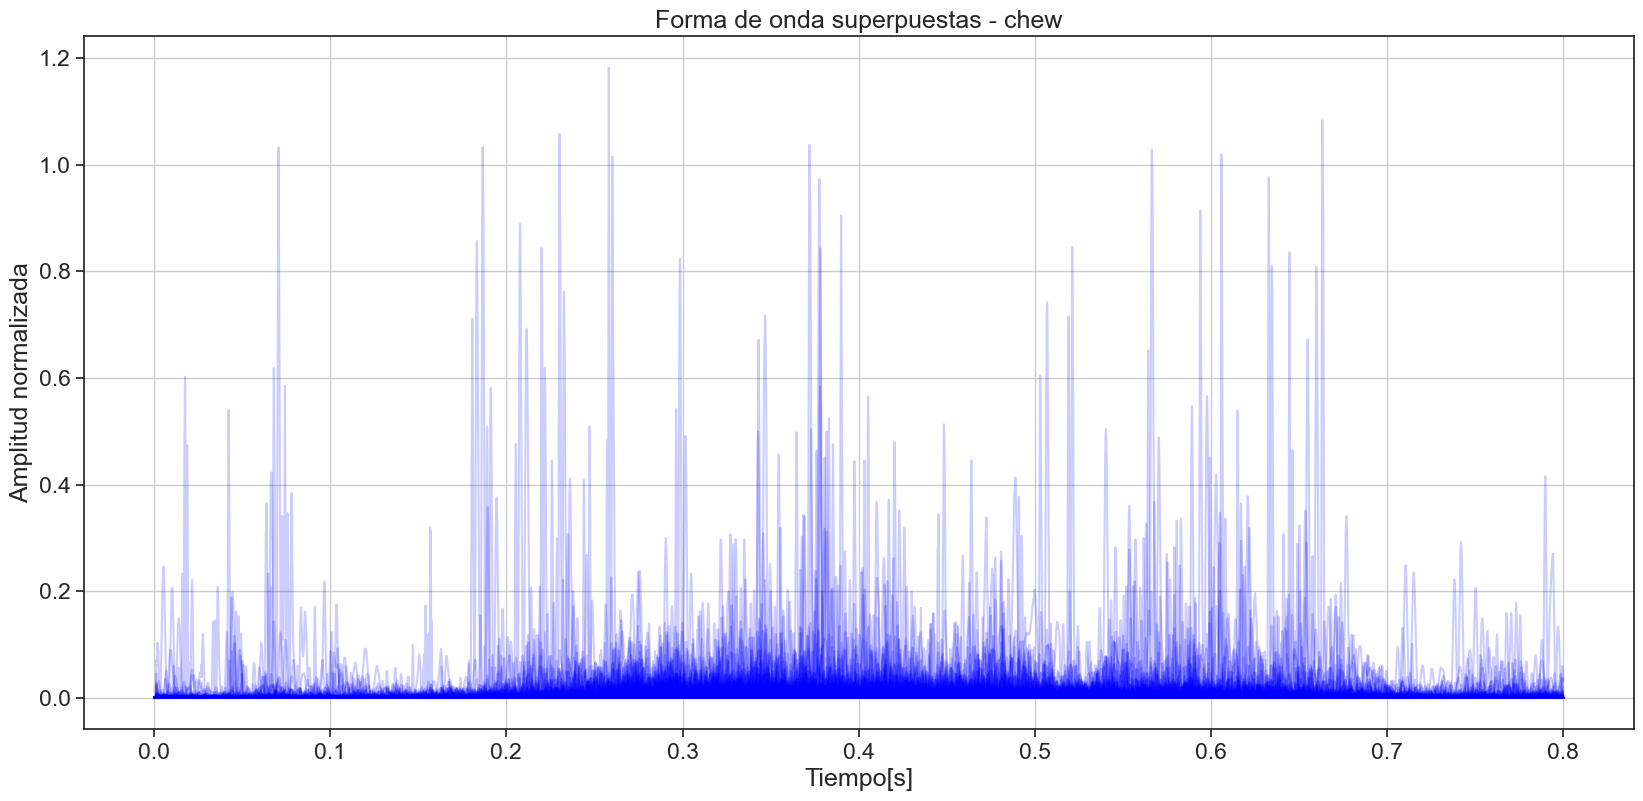

In [105]:
# Ploteamos todas las graficas de chew superpuestas
fig, ax = plt.subplots(1, 1)
bite_idxs = np.nonzero(y_clasif==1)[0]
for idx in bite_idxs:
    ax.plot([i/freq_adq for i in range(len(x_filtered[idx]))],x_filtered[idx],color='blue', alpha= 0.2)
ax.set_xlabel("Tiempo[s]")
ax.set_ylabel("Amplitud normalizada")
ax.set_title("Forma de onda superpuestas - chew")
ax.grid(True)
plt.show()

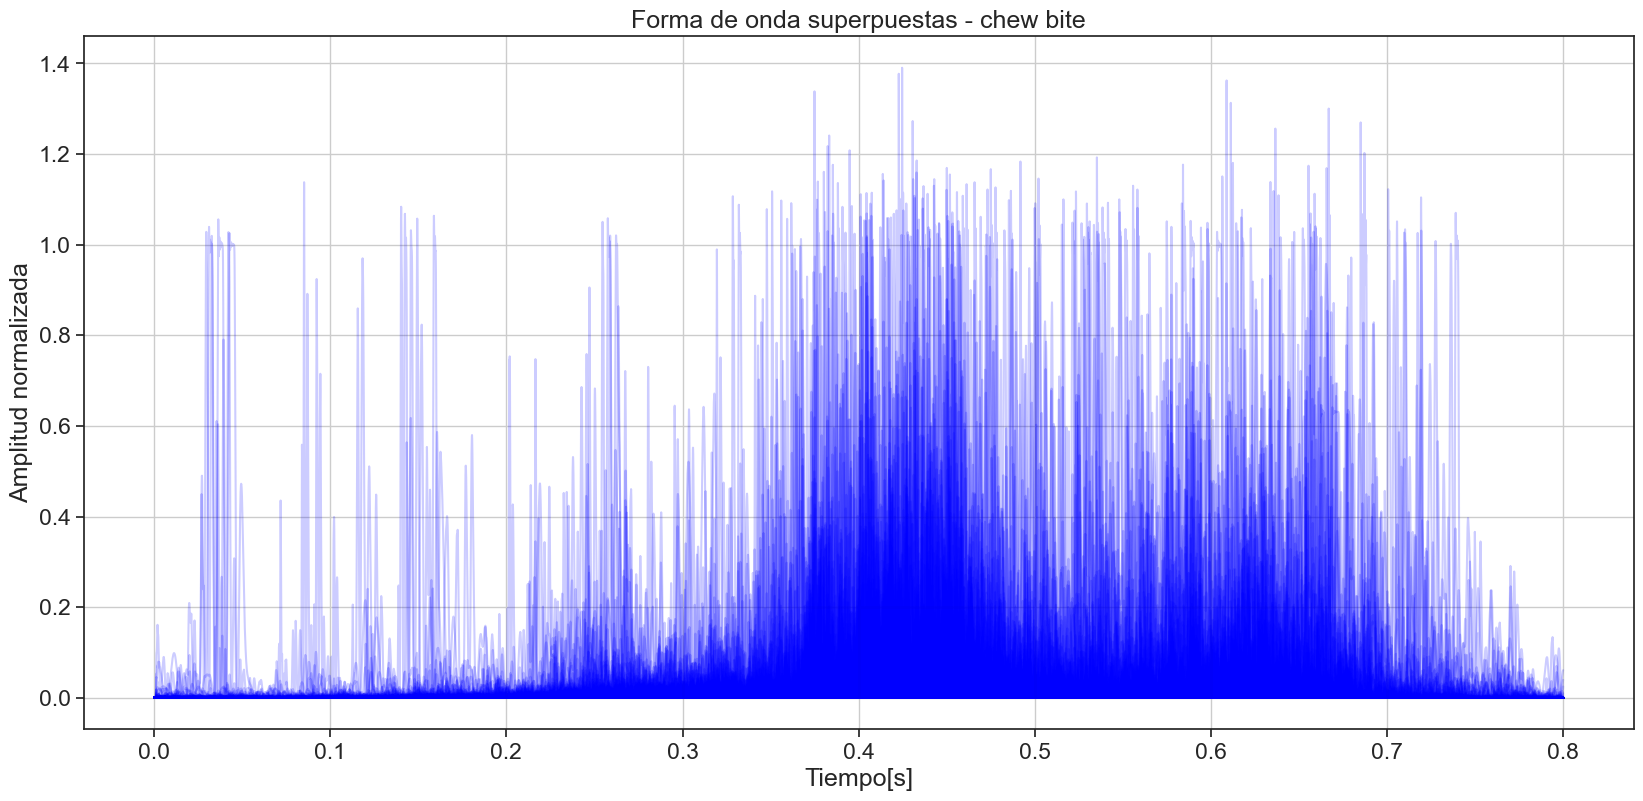

In [106]:
# Ploteamos todas las graficas de chew bite superpuestas
fig, ax = plt.subplots(1, 1)
bite_idxs = np.nonzero(y_clasif==2)[0]
for idx in bite_idxs:
    ax.plot([i/freq_adq for i in range(len(x_filtered[idx]))],x_filtered[idx],color='blue', alpha= 0.2)
ax.set_xlabel("Tiempo[s]")
ax.set_ylabel("Amplitud normalizada")
ax.set_title("Forma de onda superpuestas - chew bite")
ax.grid(True)
plt.show()

No se observa en principio una diferencia clave. Tendremos entonces que probar y encontrar estadísticos que nos den buena información y que permitan distinguir entre los eventos con métodos de inteligencia artificial

A continuación, se divide el dataset en entrenamiento y testeo y se hace un gráfico de barras para ver la distribución de eventos

In [107]:
# Dividiremos en dataset de entrenamiento y testeo
X_filter_train, X_filter_test,X_env_train, X_env_test, y_train, y_test = model_selection.train_test_split(x_filtered,
                                                                                                          x_envelope,
                                                                                                          y_clasif,
                                                                                                          test_size=0.2,
                                                                                                          shuffle=True,
                                                                                                          random_state=5,
                                                                                                          stratify = y_clasif)

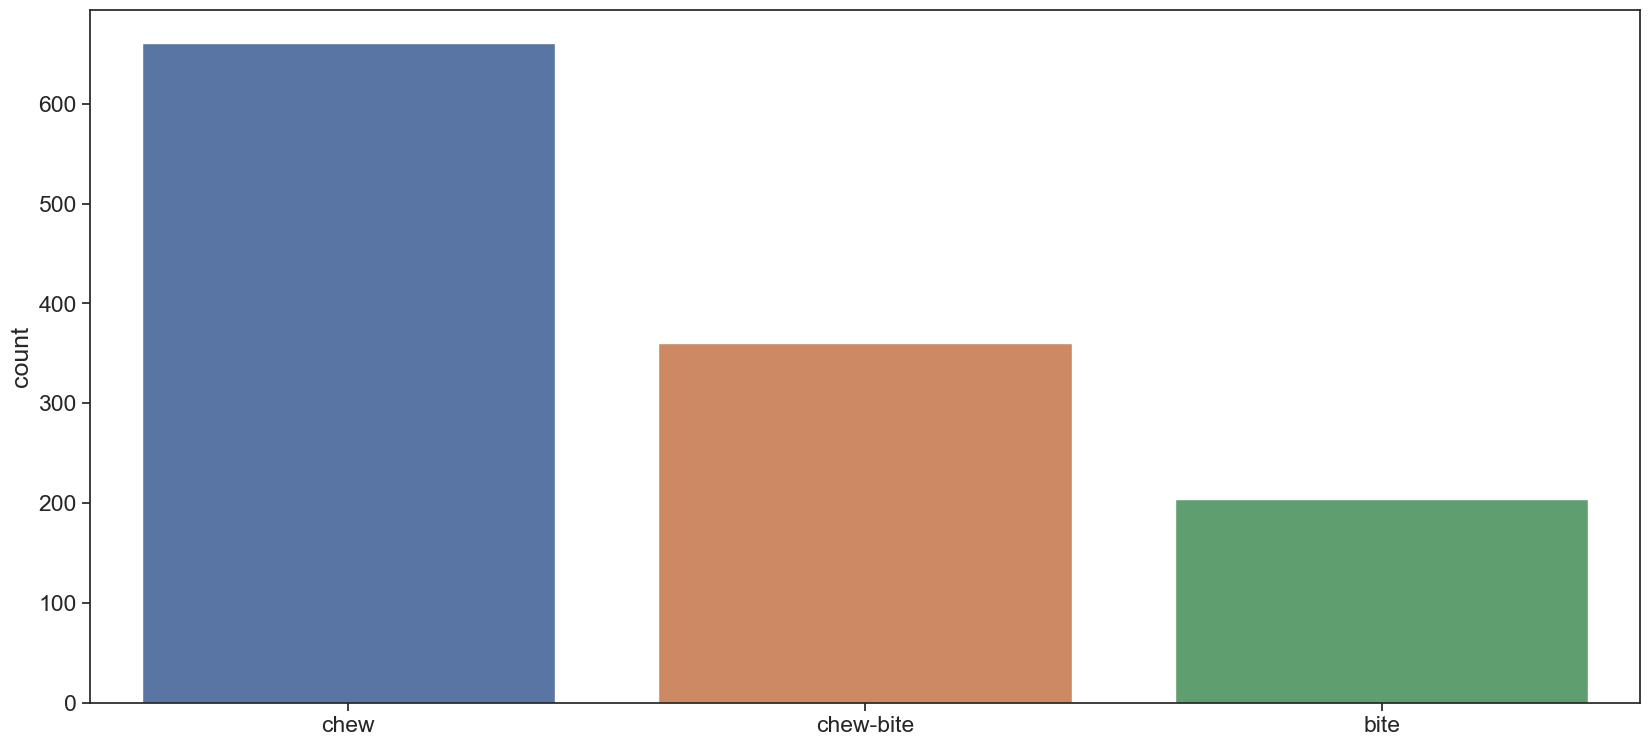

In [108]:
sns.countplot(x=np.vectorize(y_dict.get)(y_train))
plt.show()

El dataset no esta balanceado. Esto es una causa fuerte de overfitting, por lo cual hacemos under-sample para equiparar la cantidad de eventos de cada tipo

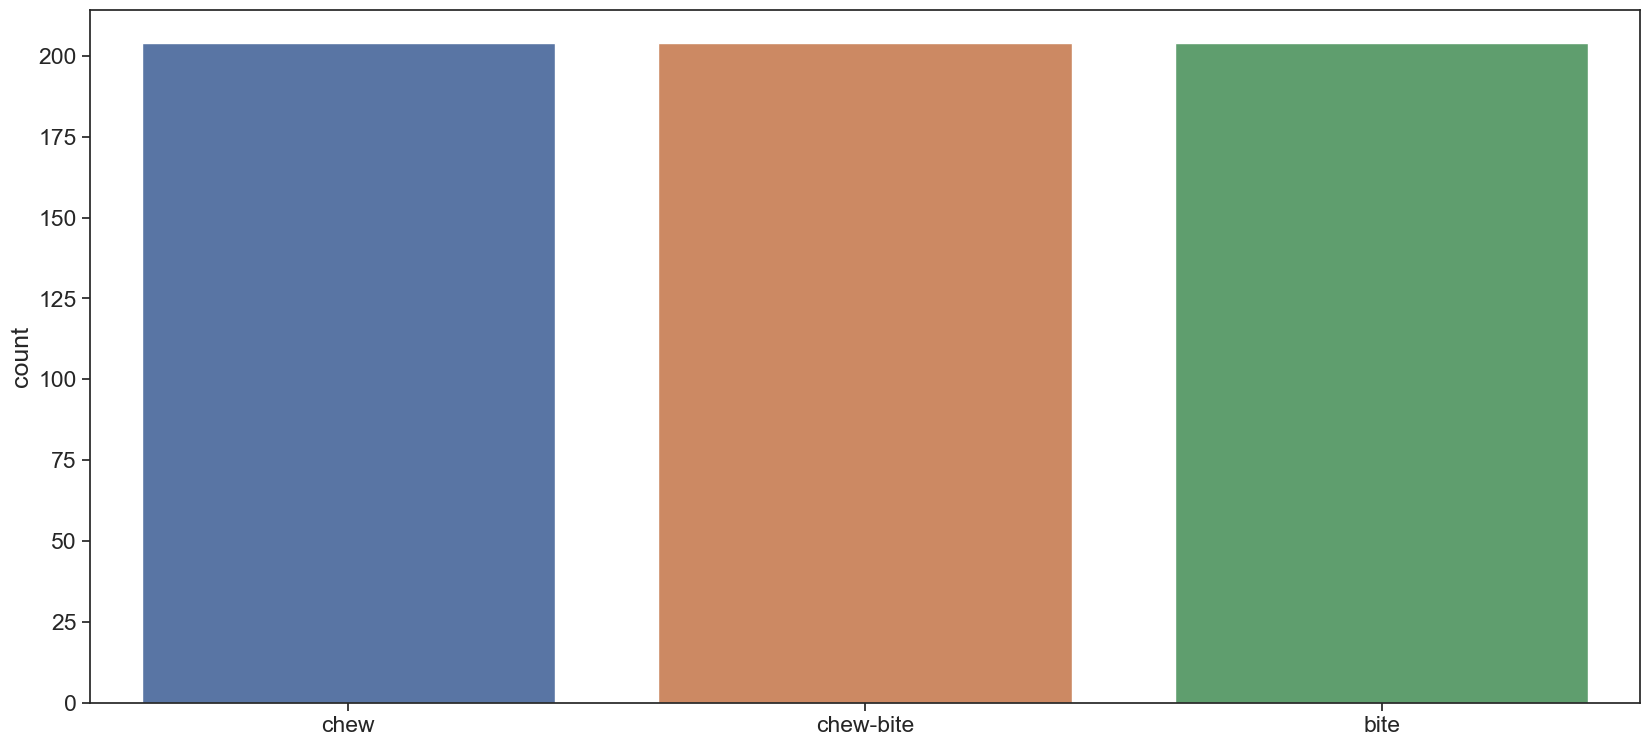

In [109]:
under_sample_qty = np.min(np.unique(y_train, return_counts=True)[1])
under_sample_idx = np.concatenate((np.nonzero(y_train==0)[0][0:under_sample_qty],
                                   np.nonzero(y_train==1)[0][0:under_sample_qty],
                                   np.nonzero(y_train==2)[0][0:under_sample_qty]))
np.random.shuffle(under_sample_idx)
X_filter_res = X_filter_train[under_sample_idx,:]
X_env_res = X_env_train[under_sample_idx,:]
y_train_res = y_train[under_sample_idx]
sns.countplot(x=np.vectorize(y_dict.get)(y_train_res))
plt.show()

In [110]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure()
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Definimos los estadísticos, entrenamos con dataset de entrenamiento y testeamos con dataset de testeo

In [111]:
from numpy import trapz
def get_characteristics(X_filter, X_env):
    X_char = pd.DataFrame()
    X_char[f'Duration'] = np.sum(X_env>0.002,axis=1)
    X_char[f'Maximum'] = np.max(X_filter,axis=1)
    X_char[f'ArgMax'] = np.argmax(X_filter,axis=1)-np.argmax(X_env>0.002,axis=1)
    X_char[f'Area'] = np.trapz(X_env,axis=1)
    return X_char

In [112]:
X_char_res = get_characteristics(X_filter_res, X_env_res)
X_char_train = get_characteristics(X_filter_train, X_env_train)
X_char_test = get_characteristics(X_filter_test, X_env_test)

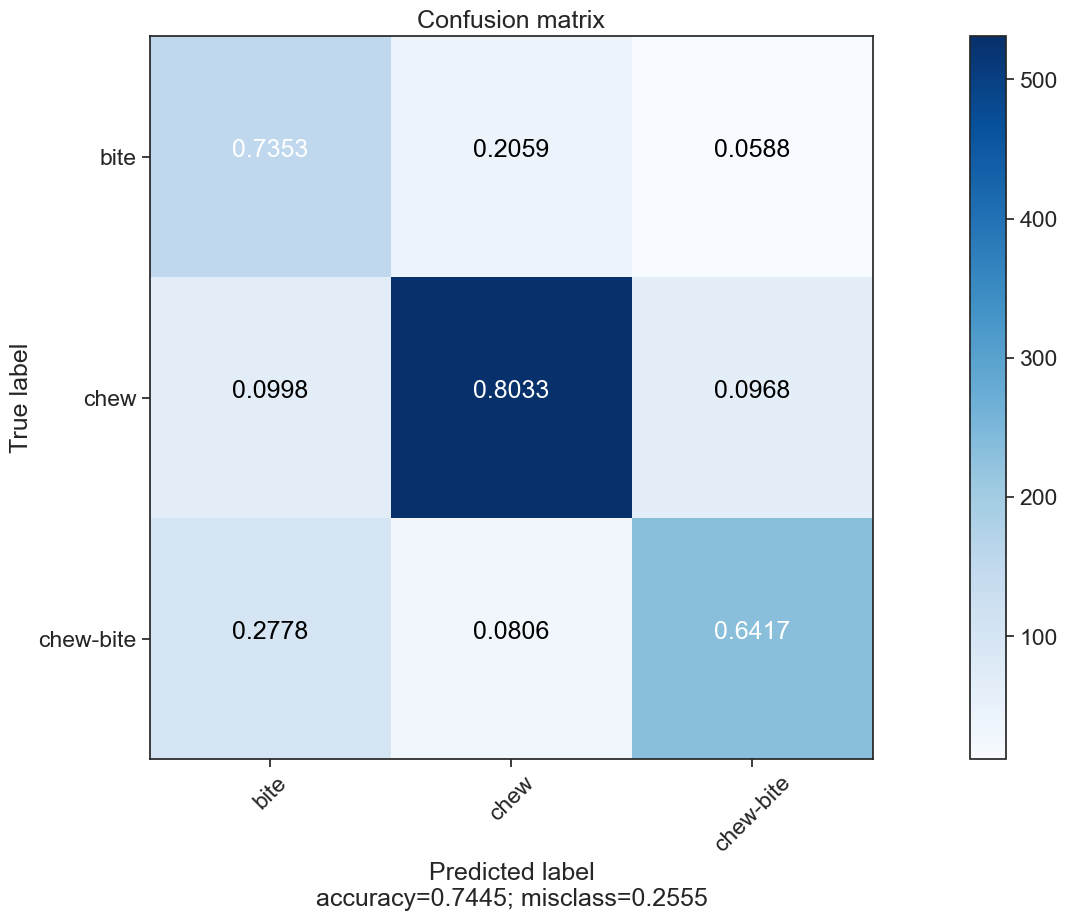

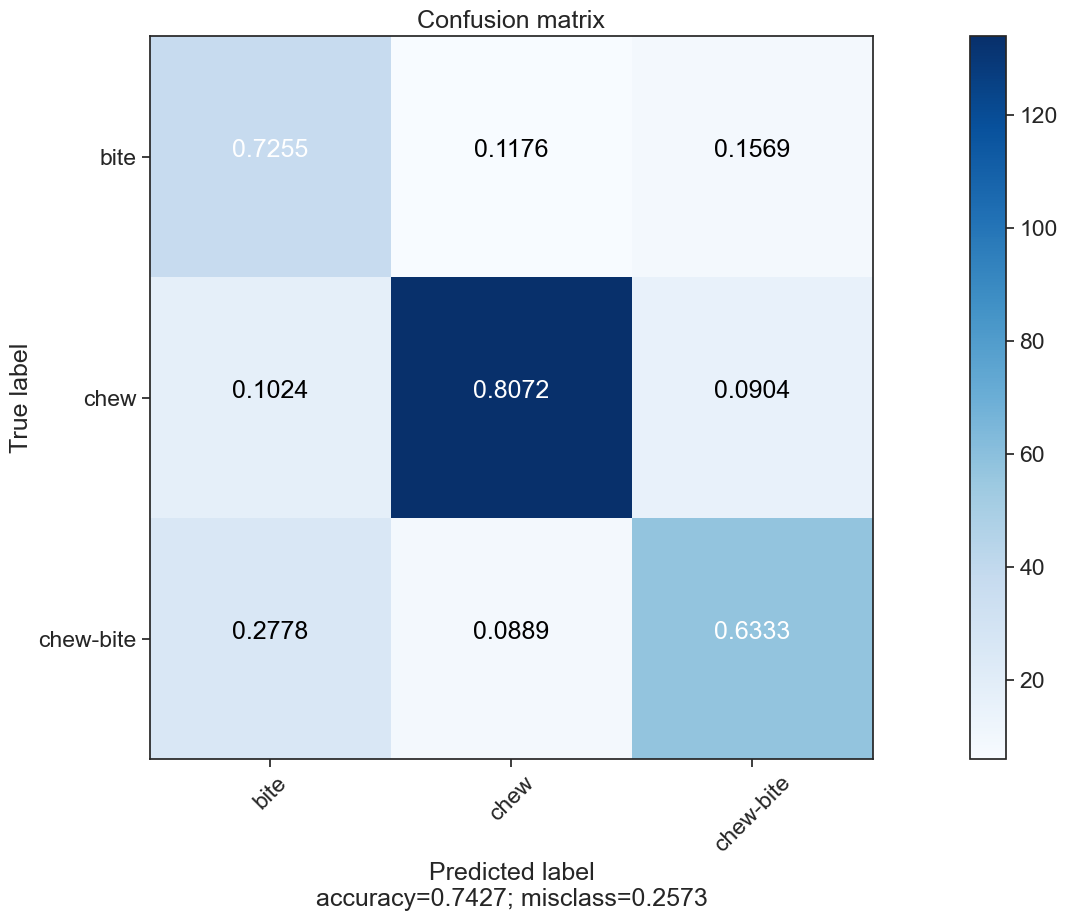

In [113]:
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_char_res,y_train_res)

y_train_predict=model.predict(X_char_train)
conf_matrix = confusion_matrix(y_train, y_train_predict)
plot_confusion_matrix(conf_matrix,target_names = y_dict.values())

y_test_predict=model.predict(X_char_test)
conf_matrix = confusion_matrix(y_test, y_test_predict)
plot_confusion_matrix(conf_matrix,target_names = y_dict.values())

Se obtiene una performance regular, con buen comportamiento para chew pero con problemas para diferenciar bite y chewbite. 

Hasta ahora, este fue el mejor resultado obtenido.

Resumimos todo el análisis anterior en clases que engloban el modelo de detección de eventos.

In [261]:
class EventClassificationModel:
    
    label_dict = {0:'bite', 1:'chew', 2:'chewbite'}
    idx_dict = {'bite':0 , 'chew':1, 'chewbite':2}
    
    def __init__(self, freq=22050, freq_resample=50):
        self.freq = freq
        self.freq_resample = freq_resample
        self.envelope_filter = EnvelopeFilter(self.freq, self.freq_resample)
        
        
    def load_file(self, path, files_len_s):
        train_labels = pd.read_csv(path+"train_labels.csv", sep=",")
        file_path= path + "data/"
        x_filtered_data = np.zeros(shape=(len(train_labels),int(files_len_s*self.freq)))
        x_envelope_data = np.zeros(shape=(len(train_labels),
                                          int(files_len_s*self.freq_resample)-self.envelope_filter.env_offset)) 
        for idx in range(len(train_labels)):
            filename = str(train_labels['filename'].iloc[idx]).rjust(4,"0") + ".wav"
            ifile = wave.open(file_path+filename)
            samples = ifile.getnframes()
            audio = ifile.readframes(samples)
            # Convert buffer to float32 using NumPy
            audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
            audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
            # Normalize float32 array so that values are between -1.0 and +1.0
            max_int16 = 2**15
            audio_normalized = audio_as_np_float32 / max_int16
            x_filtered_data[idx,:] = self.envelope_filter.noise_filter(audio_normalized)**2
            x_envelope_data[idx,:] = self.envelope_filter.fit(audio_normalized)

        return x_envelope_data, x_filtered_data, train_labels
    
    
    def get_characteristics(self, X_filter, X_env):
        X_char = pd.DataFrame()
        X_char[f'Duration'] = np.sum(X_env>0.002,axis=1)
        X_char[f'Maximum'] = np.max(X_filter,axis=1)
        X_char[f'ArgMax'] = np.argmax(X_filter,axis=1)-np.argmax(X_env>0.002,axis=1)
        X_char[f'Area'] = np.trapz(X_env,axis=1)
        return X_char
    
    
    def fit(self, path, files_len_s, test_size=0.2):
        x_envelope, x_filtered, train_labels = self.load_file(path, files_len_s)
        # Dividiremos en dataset de entrenamiento y testeo
        X_filter_train, X_filter_test,X_env_train, X_env_test, y_train, y_test = model_selection.train_test_split(x_filtered,
                                                                                                          x_envelope,
                                                                                                          y_clasif,
                                                                                                          test_size=test_size,
                                                                                                          shuffle=True,
                                                                                                          random_state=5,
                                                                                                          stratify = y_clasif)
        
        under_sample_qty = np.min(np.unique(y_train, return_counts=True)[1])
        under_sample_idx = np.concatenate((np.nonzero(y_train==0)[0][0:under_sample_qty],
                                           np.nonzero(y_train==1)[0][0:under_sample_qty],
                                           np.nonzero(y_train==2)[0][0:under_sample_qty]))
        np.random.shuffle(under_sample_idx)
        X_filter_res = X_filter_train[under_sample_idx,:]
        X_env_res = X_env_train[under_sample_idx,:]
        y_train_res = y_train[under_sample_idx]
        X_char_res = self.get_characteristics(X_filter_res, X_env_res)
        X_char_train = self.get_characteristics(X_filter_train, X_env_train)
        X_char_test = self.get_characteristics(X_filter_test, X_env_test)
        
        self.model = tree.DecisionTreeClassifier(max_depth=5)
        self.model.fit(X_char_res,y_train_res)
        y_train_predict=self.model.predict(X_char_train)
        y_test_predict=self.model.predict(X_char_test)
        
        train_score = []
        for y_class in np.unique(y_train):
            aux = {}
            aux['class'] = self.label_dict[y_class]
            aux['accuracy'] = accuracy_score(y_train==y_class, y_train_predict==y_class)
            aux['f1-score'] = f1_score(y_train==y_class, y_train_predict==y_class)
            train_score.append(aux)
            
        test_score = []
        for y_class in np.unique(y_test):
            aux = {}
            aux['class'] = self.label_dict[y_class]
            aux['accuracy'] = accuracy_score(y_test==y_class, y_test_predict==y_class)
            aux['f1-score'] = f1_score(y_test==y_class, y_test_predict==y_class)
            test_score.append(aux)
            
        return train_score, test_score
    
    
    def predict(self, audio):
        x_filtered = self.envelope_filter.noise_filter(audio)**2
        x_envelope = self.envelope_filter.fit(audio)
        x_char = self.get_characteristics(x_filtered[np.newaxis,:], x_envelope[np.newaxis,:])
        return self.model.predict(x_char)

In [262]:
event_classification_model = EventClassificationModel(22050,50)
train_score, test_score = event_classification_model.fit("Audios/Clasificacion eventos/", 0.8)
print("Train score: ")
print(*train_score, sep = "\n")
print("----------------------------------------------------------------------------------------------------------------------")
print("Test score: ")
print(*test_score, sep = "\n")

Train score: 
{'class': 'bite', 'accuracy': 0.8791836734693877, 'f1-score': 0.6768558951965066}
{'class': 'chew', 'accuracy': 0.8375510204081633, 'f1-score': 0.8424386381631037}
{'class': 'chewbite', 'accuracy': 0.8620408163265306, 'f1-score': 0.7681755829903978}
----------------------------------------------------------------------------------------------------------------------
Test score: 
{'class': 'bite', 'accuracy': 0.8436482084690554, 'f1-score': 0.5471698113207548}
{'class': 'chew', 'accuracy': 0.8403908794788274, 'f1-score': 0.8463949843260188}
{'class': 'chewbite', 'accuracy': 0.8013029315960912, 'f1-score': 0.6772486772486773}


Finalmente, unificamos modelo de detección y modelo de clasificación y calculamos el accuracy y el coeficiente de dice para cada categoria con los audios del caso anterior

In [307]:
class EventDetectionAndClassificationModel:
    
    def __init__(self, eventDetectionModel, eventClassificationModel):
        self.eventDetectionModel = eventDetectionModel
        self.eventClassificationModel = eventClassificationModel
        self.detection_ratio = eventDetectionModel.freq / eventDetectionModel.freq_resample
        
    def test(self, files):
        audios = []
        tmarks = []
        for filename in files:
            t, audio, tmark = self.eventDetectionModel.load_file(filename)
            audios.append(audio)
            tmarks.append(tmark)
            
        event_detection = self.eventDetectionModel.predict(files)
        
        score = []
        
        for i in range(len(event_detection)):

            event_aux = event_detection[i]
            event_start = 0
            event_end = 0
            idx = 0

            while(idx < len(event_aux)):

                event_start = np.nonzero(event_aux[idx:])[0]
                if(len(event_start)==0):
                    break
                else:
                    event_start = event_start[0] + idx

                event_end = np.nonzero(1-event_aux[event_start:])[0]
                if len(event_end)==0:
                    event_end = len(event_aux) - 1
                else:
                    event_end = event_end[0] + event_start

                audio_event = audios[i][int(event_start*self.detection_ratio): int(event_end*self.detection_ratio)]
                audio_class = self.eventClassificationModel.predict(audio_event)
                event_aux[event_start:event_end] = audio_class + 1

                idx = event_end + 1

            score_file = []
            for y_class in np.unique(tmarks[i]['class']):
                aux_mark = tmarks[i].loc[tmarks[i]['class']==y_class]

                event_class = (event_aux == (self.eventClassificationModel.idx_dict[y_class]+1))
                accuracy_class  = DetectionAccuracy.fit(event_class, aux_mark, self.eventDetectionModel.freq_resample)
                dice_class = DiceCoef.fit(event_class, aux_mark, self.eventDetectionModel.freq_resample)

                score_class = {}
                score_class['class'] = y_class
                score_class['accuracy'] = accuracy_class
                score_class['dice'] = dice_class

                score_file.append(score_class)
            score.append(score_file) 
        return score
    
    
    def predict(self, files):    
        audios = []
        for filename in files:
            t, audio, tmark = self.eventDetectionModel.load_file(filename)
            audios.append(audio)
            
        event_detection = self.eventDetectionModel.predict(files)
        
        for i in range(len(event_detection)):

            event_start = 0
            event_end_idx = 0
            idx = 0

            while(idx < len(event_detection[i])):

                event_start = np.nonzero(event_detection[i][idx:])[0]
                if(len(event_start)==0):
                    break
                else:
                    event_start = event_start[0] + idx

                event_end = np.nonzero(1-event_detection[i][event_start:])[0]
                if len(event_end)==0:
                    event_end = len(event_detection[i]) - 1
                else:
                    event_end = event_end[0] + event_start

                audio_event = audios[i][int(event_start*self.detection_ratio): int(event_end*self.detection_ratio)]
                audio_class = self.eventClassificationModel.predict(audio_event)
                event_detection[i][event_start:event_end] = audio_class + 1
                
        return event_detection

In [308]:
files = [ "./Audios/Detección de eventos masticatorios/recording_01",
         "./Audios/Detección de eventos masticatorios/recording_51",
         './Audios/Detección de eventos masticatorios/recording_52']

event_detection_and_classification_model = EventDetectionAndClassificationModel(event_detection_model,
                                                                                event_classification_model)
scores = event_detection_and_classification_model.test(files)

for score in scores:
    print("--------------------------------")
    print(*score,sep='\n')

--------------------------------
{'class': 'bite', 'accuracy': 0.4444444444444444, 'dice': 0.1325811001410437}
{'class': 'chew', 'accuracy': 0.8867924528301887, 'dice': 0.6852248394004282}
{'class': 'chewbite', 'accuracy': 0.5142857142857142, 'dice': 0.16161616161616163}
--------------------------------
{'class': 'bite', 'accuracy': 0.6222222222222222, 'dice': 0.5536723163841808}
{'class': 'chew', 'accuracy': 0.8, 'dice': 0.5778275475923852}
{'class': 'chewbite', 'accuracy': 0.6521739130434783, 'dice': 0.34408602150537637}
--------------------------------
{'class': 'bite', 'accuracy': 0.52, 'dice': 0.16482803374432187}
{'class': 'chew', 'accuracy': 0.8270676691729323, 'dice': 0.6752450980392157}
{'class': 'chewbite', 'accuracy': 0.5714285714285714, 'dice': 0.27598407784166296}


Observamos una buena performance para el caso de chew pero mala para el caso de bite y chewbite. Evidentemente es necesario un reajuste de ambos modelos.

-------------------------------------------------------------------------------------------------------------------------------

## Detectar actividad alimentaria